In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pystan 
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pickle
from tqdm.notebook import tqdm as tqdm
from concurrent.futures import ProcessPoolExecutor
import warnings

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
sm = pickle.load(open('modified Weibull multi-level MVN.pkl', 'rb'))
samples = pickle.load(open('Samples extracted modfied Weibull multi-level MVN stan.pkl', 'rb'))
rep_num_Bayesian = samples['Paras0_between'].shape[0]

In [3]:
delta0_mean = np.exp(np.mean(samples['logdelta0_between']))
print(delta0_mean)
print(delta0_mean*2)
print(delta0_mean*4)
print(delta0_mean*6)

1.295613828429793
2.591227656859586
5.182455313719172
7.773682970578758


In [4]:
sim_num = 10000
revo_num = 100
thermal_trial_lim = 100
L_para = 1
sigma_adjust_para = 1
cell_count = 10**4
processor_num = 6

sigma_within_logdelta = 0.012877201899668568
sigma_within_logpower = 0.02248441898117806

corr = -0.329670291302809

cor = np.array([[1, corr], [corr, 1]])

sigs_within = np.array([[sigma_within_logdelta, 0], [0, sigma_within_logpower]])

cov_within = sigs_within@cor@sigs_within

In [5]:
def heat_rev(seed_ID):
    np.random.seed(seed=seed_ID)
    #cell_count = np.max([np.round(10**np.random.normal(4,1)),1])
    t_1cell_death_time =  -np.inf
    logPara_history = pd.DataFrame()
    ID_Bayesian = np.random.choice(range(rep_num_Bayesian))
    logpara_mean = samples["Paras0_between"][ID_Bayesian]
    cov_between = samples["cov_between"][ID_Bayesian]
    cov_within = samples["cov_within"][ID_Bayesian]
    cov_within = sigma_adjust_para * cov_within
    #cov_within = samples["cov_within"][ID_Bayesian,:]
    for i in tqdm(range(revo_num+1),leave=False):
        if i==0:
            logPara_tmp = np.random.multivariate_normal(logpara_mean, cov_between)
            logPara_history = pd.concat([logPara_history, pd.DataFrame([logPara_tmp], index = [0], columns = ['logdelta '+str(seed_ID), 'logpower '+str(seed_ID)])], axis=0)
        if i!=0:
            cell_counts = int(cell_count)

            logPara_candi = np.random.multivariate_normal(logPara_tmp, cov_within, size = cell_counts)
            L_tmp = sp.stats.multivariate_normal.pdf(logPara_tmp, mean=logpara_mean, cov=cov_between)
            L_candi = sp.stats.multivariate_normal.pdf(logPara_candi, mean=logpara_mean, cov=cov_between)
            LR = (L_candi/L_tmp)**L_para
            LR = np.minimum(LR, [1])
            P_rev = np.random.uniform(0,1, size = cell_counts)
            PN = LR - P_rev
            PN = np.repeat(PN, 2).reshape(cell_counts, 2)
            logPara_tmp = np.tile(logPara_tmp, (cell_counts, 1))
            logPara_test = np.where(PN >= 0, logPara_candi, logPara_tmp)
            delta = np.exp(logPara_test[:,0])
            power = np.exp(logPara_test[:,1])
            P_cum = np.random.uniform(0,1, size = cell_counts)
            t_1cell_death_time_list = 6*delta*(-1*np.log10(1-P_cum)/6)**(1/power)
            survivors_index_list = np.where(t_1cell_death_time_list>t_heating)
            if len(survivors_index_list[0])!=0:
                selected_survior_index = np.random.choice(survivors_index_list[0])
                logPara_tmp = np.round(logPara_test[selected_survior_index], 4)
            if len(survivors_index_list[0])==0:
                logPara_test[0,0] = np.nan
                logPara_test[0,1] = np.nan
                logPara_tmp = logPara_test[0]
            logPara_history = pd.concat([logPara_history, pd.DataFrame([logPara_tmp], index = [i], columns = ['logdelta '+str(seed_ID), 'logpower '+str(seed_ID)])], axis=0)
    return logPara_history

In [6]:
t_heating = 2*delta0_mean
warnings.simplefilter('ignore', RuntimeWarning)
Sim_results =[]
ns = range(sim_num)
with ProcessPoolExecutor(processor_num) as e:
    ret = e.map(heat_rev, ns)
logPara_histories = [r for r in ret]
logPara_histories = pd.concat(logPara_histories, axis=1)

In [7]:
logPara_histories

logdelta 0  logpower 0  logdelta 1  logpower 1  logdelta 2  logpower 2  \
0      0.302447    0.431105     0.22697   -0.231822    0.417707    0.036302   
1      0.189900    0.418200     0.22700   -0.231800    0.594800   -0.051900   
2      0.234500    0.368600     0.22700   -0.231800    0.662900    0.108400   
3      0.165800    0.364900     0.07400   -0.098500    0.686800    0.140800   
4      0.165800    0.364900     0.15830    0.171000    0.488100    0.484100   
..          ...         ...         ...         ...         ...         ...   
96     0.496000    0.771500     0.39330    0.403500    0.405000    0.397200   
97     0.447300    0.839700     0.44840    0.547500    0.405000    0.397200   
98     0.531600    0.750500     0.44840    0.547500    0.400200    0.398400   
99     0.631500    0.589500     0.54100    0.546300    0.477500    0.171300   
100    0.721800    0.427600     0.59480    0.241000    0.412200    0.160000   

     logdelta 3  logpower 3  logdelta 4  logpower 4  ...  logdelta 9995  \
0      0.030729    0.015013    0.396423    0.235764  ...       0.263001   
1      0.054400    0.090400    0.304300    0.372300  ...       0.249900   
2      0.054400    0.090400    0.339000    0.273900  ...       0.360300   
3      0.023300    0.073100    0.485200    0.073300  ...       0.326300   
4     -0.031600    0.251600    0.412300    0.179600  ...       0.326300   
..          ...         ...         ...         ...  ...            ...   
96     0.552200    0.608200    0.644700    0.242900  ...       0.758800   
97     0.486400    0.593200    0.516000    0.468000  ...       0.758800   
98     0.486400    0.593200    0.678900    0.359700  ...       0.886200   
99     0.360400    0.664100    0.622200    0.426600  ...       0.886200   
100    0.292900    0.746800    0.517900    0.482600  ...       0.743900   

     logpower 9995  logdelta 9996  logpower 9996  logdelta 9997  \
0         0.220955       0.108068       0.283268       0.085549   
1         0.371600       0.108100       0.283300       0.099900   
2         0.231800       0.176900       0.144000       0.068700   
3         0.263800       0.244100       0.211600       0.004200   
4         0.263800       0.390200       0.413500       0.139700   
..             ...            ...            ...            ...   
96        0.717200       0.478500       0.594700       0.718800   
97        0.717200       0.478500       0.594700       0.789900   
98        0.726800       0.367100       0.699400       0.802100   
99        0.726800       0.186600       0.560400       0.835100   
100       0.838700       0.186600       0.560400       0.782600   

     logpower 9997  logdelta 9998  logpower 9998  logdelta 9999  logpower 9999  
0        -0.182882       0.632158       0.487543       0.287387      -0.254249  
1         0.067500       0.743600       0.539100       0.287400      -0.254200  
2         0.172000       0.743600       0.539100       0.287400      -0.254200  
3         0.107000       0.743600       0.539100       0.377300       0.046400  
4         0.225700       0.743600       0.539100       0.437500       0.273200  
..             ...            ...            ...            ...            ...  
96        0.382600       0.758600       0.486300       0.912700       0.130200  
97        0.160000       0.758600       0.486300       0.847900       0.014800  
98        0.103400       0.758600       0.486300       0.736400       0.245300  
99        0.221500       0.944400       0.340100       0.528400       0.554000  
100       0.306200       0.944400       0.340100       0.528400       0.554000  

[101 rows x 20000 columns]

palette = sns.color_palette(n_colors = sim_num)
for j in tqdm(range(sim_num),leave=False):
    plt.plot(logPara_histories['logdelta '+str(j)],logPara_histories['logpower '+str(j)], linewidth = 0.5, color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    plt.scatter(logPara_histories['logdelta '+str(j)].head(1),logPara_histories['logpower '+str(j)].head(1), marker = '.', color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    if np.isnan(logPara_histories['logdelta '+str(j)].tail(1).iloc[0]):
        plt.scatter(logPara_histories['logdelta '+str(j)].dropna(how='all', axis=0).tail(1),logPara_histories['logpower '+str(j)].dropna(how='all', axis=0).tail(1), marker = 'x', color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    if logPara_histories['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(logPara_histories['logdelta '+str(j)].tail(1),logPara_histories['logpower '+str(j)].tail(1), marker = '>', color = palette[j], alpha=0.1)
plt.show()

palette = sns.color_palette(n_colors = sim_num)
for j in tqdm(range(sim_num),leave=False):
    plt.plot(np.exp(logPara_histories['logdelta '+str(j)]),np.exp(logPara_histories['logpower '+str(j)]), linewidth = 0.5, color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].head(1)),np.exp(logPara_histories['logpower '+str(j)].head(1)), marker = '.', color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    if np.isnan(logPara_histories['logdelta '+str(j)].tail(1).iloc[0]):
        plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].dropna(how='all', axis=0).tail(1)),np.exp(logPara_histories['logpower '+str(j)].dropna(how='all', axis=0).tail(1)), marker = 'x', color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    if logPara_histories['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].tail(1)),np.exp(logPara_histories['logpower '+str(j)].tail(1)), marker = '>', color = palette[j], alpha=0.1)
plt.show()

In [8]:
with open('Simulated revolution.pkl', 'wb') as g:
    pickle.dump(logPara_histories, g)

In [9]:
logPara_histories_rev = logPara_histories

In [10]:
logPara_histories_rev

logdelta 0  logpower 0  logdelta 1  logpower 1  logdelta 2  logpower 2  \
0      0.302447    0.431105     0.22697   -0.231822    0.417707    0.036302   
1      0.189900    0.418200     0.22700   -0.231800    0.594800   -0.051900   
2      0.234500    0.368600     0.22700   -0.231800    0.662900    0.108400   
3      0.165800    0.364900     0.07400   -0.098500    0.686800    0.140800   
4      0.165800    0.364900     0.15830    0.171000    0.488100    0.484100   
..          ...         ...         ...         ...         ...         ...   
96     0.496000    0.771500     0.39330    0.403500    0.405000    0.397200   
97     0.447300    0.839700     0.44840    0.547500    0.405000    0.397200   
98     0.531600    0.750500     0.44840    0.547500    0.400200    0.398400   
99     0.631500    0.589500     0.54100    0.546300    0.477500    0.171300   
100    0.721800    0.427600     0.59480    0.241000    0.412200    0.160000   

     logdelta 3  logpower 3  logdelta 4  logpower 4  ...  logdelta 9995  \
0      0.030729    0.015013    0.396423    0.235764  ...       0.263001   
1      0.054400    0.090400    0.304300    0.372300  ...       0.249900   
2      0.054400    0.090400    0.339000    0.273900  ...       0.360300   
3      0.023300    0.073100    0.485200    0.073300  ...       0.326300   
4     -0.031600    0.251600    0.412300    0.179600  ...       0.326300   
..          ...         ...         ...         ...  ...            ...   
96     0.552200    0.608200    0.644700    0.242900  ...       0.758800   
97     0.486400    0.593200    0.516000    0.468000  ...       0.758800   
98     0.486400    0.593200    0.678900    0.359700  ...       0.886200   
99     0.360400    0.664100    0.622200    0.426600  ...       0.886200   
100    0.292900    0.746800    0.517900    0.482600  ...       0.743900   

     logpower 9995  logdelta 9996  logpower 9996  logdelta 9997  \
0         0.220955       0.108068       0.283268       0.085549   
1         0.371600       0.108100       0.283300       0.099900   
2         0.231800       0.176900       0.144000       0.068700   
3         0.263800       0.244100       0.211600       0.004200   
4         0.263800       0.390200       0.413500       0.139700   
..             ...            ...            ...            ...   
96        0.717200       0.478500       0.594700       0.718800   
97        0.717200       0.478500       0.594700       0.789900   
98        0.726800       0.367100       0.699400       0.802100   
99        0.726800       0.186600       0.560400       0.835100   
100       0.838700       0.186600       0.560400       0.782600   

     logpower 9997  logdelta 9998  logpower 9998  logdelta 9999  logpower 9999  
0        -0.182882       0.632158       0.487543       0.287387      -0.254249  
1         0.067500       0.743600       0.539100       0.287400      -0.254200  
2         0.172000       0.743600       0.539100       0.287400      -0.254200  
3         0.107000       0.743600       0.539100       0.377300       0.046400  
4         0.225700       0.743600       0.539100       0.437500       0.273200  
..             ...            ...            ...            ...            ...  
96        0.382600       0.758600       0.486300       0.912700       0.130200  
97        0.160000       0.758600       0.486300       0.847900       0.014800  
98        0.103400       0.758600       0.486300       0.736400       0.245300  
99        0.221500       0.944400       0.340100       0.528400       0.554000  
100       0.306200       0.944400       0.340100       0.528400       0.554000  

[101 rows x 20000 columns]

In [11]:
logPara_histories.dropna(axis=1)

logdelta 0  logpower 0  logdelta 1  logpower 1  logdelta 2  logpower 2  \
0      0.302447    0.431105     0.22697   -0.231822    0.417707    0.036302   
1      0.189900    0.418200     0.22700   -0.231800    0.594800   -0.051900   
2      0.234500    0.368600     0.22700   -0.231800    0.662900    0.108400   
3      0.165800    0.364900     0.07400   -0.098500    0.686800    0.140800   
4      0.165800    0.364900     0.15830    0.171000    0.488100    0.484100   
..          ...         ...         ...         ...         ...         ...   
96     0.496000    0.771500     0.39330    0.403500    0.405000    0.397200   
97     0.447300    0.839700     0.44840    0.547500    0.405000    0.397200   
98     0.531600    0.750500     0.44840    0.547500    0.400200    0.398400   
99     0.631500    0.589500     0.54100    0.546300    0.477500    0.171300   
100    0.721800    0.427600     0.59480    0.241000    0.412200    0.160000   

     logdelta 3  logpower 3  logdelta 4  logpower 4  ...  logdelta 9995  \
0      0.030729    0.015013    0.396423    0.235764  ...       0.263001   
1      0.054400    0.090400    0.304300    0.372300  ...       0.249900   
2      0.054400    0.090400    0.339000    0.273900  ...       0.360300   
3      0.023300    0.073100    0.485200    0.073300  ...       0.326300   
4     -0.031600    0.251600    0.412300    0.179600  ...       0.326300   
..          ...         ...         ...         ...  ...            ...   
96     0.552200    0.608200    0.644700    0.242900  ...       0.758800   
97     0.486400    0.593200    0.516000    0.468000  ...       0.758800   
98     0.486400    0.593200    0.678900    0.359700  ...       0.886200   
99     0.360400    0.664100    0.622200    0.426600  ...       0.886200   
100    0.292900    0.746800    0.517900    0.482600  ...       0.743900   

     logpower 9995  logdelta 9996  logpower 9996  logdelta 9997  \
0         0.220955       0.108068       0.283268       0.085549   
1         0.371600       0.108100       0.283300       0.099900   
2         0.231800       0.176900       0.144000       0.068700   
3         0.263800       0.244100       0.211600       0.004200   
4         0.263800       0.390200       0.413500       0.139700   
..             ...            ...            ...            ...   
96        0.717200       0.478500       0.594700       0.718800   
97        0.717200       0.478500       0.594700       0.789900   
98        0.726800       0.367100       0.699400       0.802100   
99        0.726800       0.186600       0.560400       0.835100   
100       0.838700       0.186600       0.560400       0.782600   

     logpower 9997  logdelta 9998  logpower 9998  logdelta 9999  logpower 9999  
0        -0.182882       0.632158       0.487543       0.287387      -0.254249  
1         0.067500       0.743600       0.539100       0.287400      -0.254200  
2         0.172000       0.743600       0.539100       0.287400      -0.254200  
3         0.107000       0.743600       0.539100       0.377300       0.046400  
4         0.225700       0.743600       0.539100       0.437500       0.273200  
..             ...            ...            ...            ...            ...  
96        0.382600       0.758600       0.486300       0.912700       0.130200  
97        0.160000       0.758600       0.486300       0.847900       0.014800  
98        0.103400       0.758600       0.486300       0.736400       0.245300  
99        0.221500       0.944400       0.340100       0.528400       0.554000  
100       0.306200       0.944400       0.340100       0.528400       0.554000  

[101 rows x 19858 columns]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

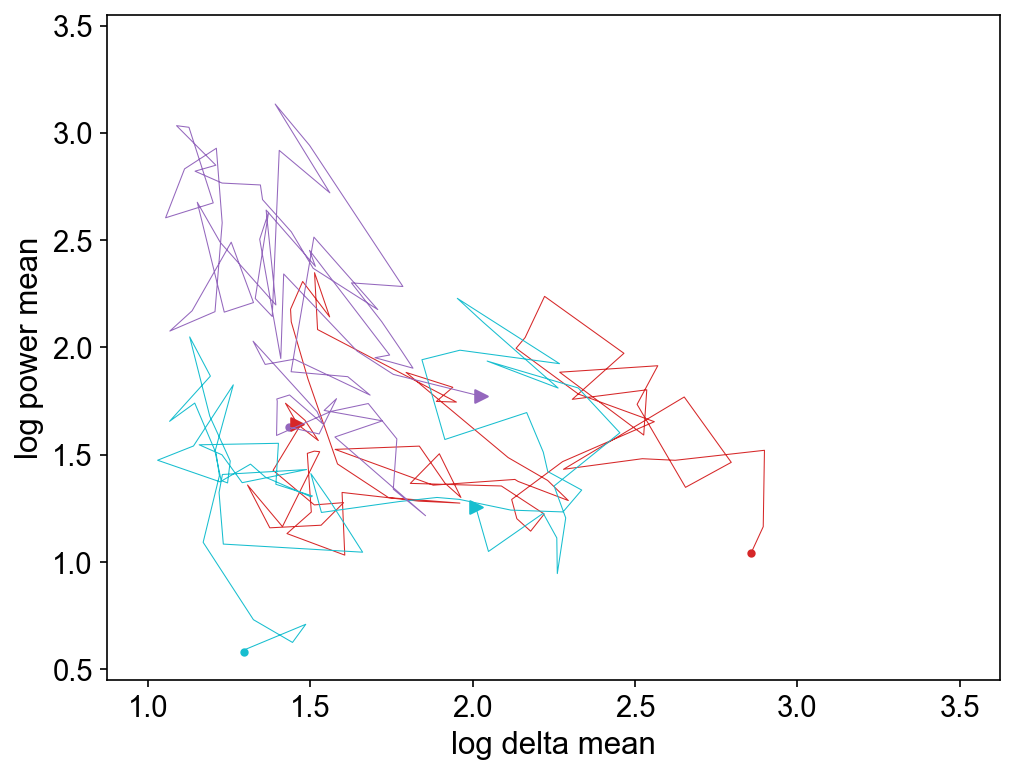

In [12]:
plt.figure(figsize=[6.4*1.2, 4.8*1.2], dpi=150)
plt.rcParams["font.family"] = "Arial"
plt.xlabel("log delta mean",size=15,fontname="Arial")
plt.ylabel("log power mean",size=15,fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim([1.0-0.125,3.5+0.125])
plt.ylim([0.5-0.05,3.5+0.05])

palette = sns.color_palette(n_colors = sim_num)
watch_list = [153, 309, 344]
for j in tqdm(watch_list,leave=False):
    plt.plot(np.exp(logPara_histories['logdelta '+str(j)]),np.exp(logPara_histories['logpower '+str(j)]), linewidth = 0.5, color = palette[j])

for j in tqdm(watch_list,leave=False):
    plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].head(1)),np.exp(logPara_histories['logpower '+str(j)].head(1)), marker = '.', color = palette[j])

for j in tqdm(watch_list,leave=False):
    if np.isnan(logPara_histories['logdelta '+str(j)].tail(1).iloc[0]):
        plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].dropna(how='all', axis=0).tail(1)),np.exp(logPara_histories['logpower '+str(j)].dropna(how='all', axis=0).tail(1)), marker = 'x', color = palette[j])

for j in tqdm(watch_list,leave=False):
    if logPara_histories['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].tail(1)),np.exp(logPara_histories['logpower '+str(j)].tail(1)), marker = '>', color = palette[j])

plt.savefig("Evo_Fig/Rev_1 simulated parameters.pdf", bbox_inches="tight", dpi=150)
plt.show()

In [13]:
logPara_histories_rev_delta = logPara_histories_rev[logPara_histories_rev.columns[logPara_histories_rev.columns.str.startswith("logdelta")]]
logPara_histories_rev_delta

logdelta 0  logdelta 1  logdelta 2  logdelta 3  logdelta 4  logdelta 5  \
0      0.302447     0.22697    0.417707    0.030729    0.396423     0.25996   
1      0.189900     0.22700    0.594800    0.054400    0.304300     0.30440   
2      0.234500     0.22700    0.662900    0.054400    0.339000     0.45800   
3      0.165800     0.07400    0.686800    0.023300    0.485200     0.47930   
4      0.165800     0.15830    0.488100   -0.031600    0.412300     0.57040   
..          ...         ...         ...         ...         ...         ...   
96     0.496000     0.39330    0.405000    0.552200    0.644700     0.38070   
97     0.447300     0.44840    0.405000    0.486400    0.516000     0.36750   
98     0.531600     0.44840    0.400200    0.486400    0.678900     0.34110   
99     0.631500     0.54100    0.477500    0.360400    0.622200     0.15540   
100    0.721800     0.59480    0.412200    0.292900    0.517900     0.18960   

     logdelta 6  logdelta 7  logdelta 8  logdelta 9  ...  logdelta 9990  \
0      0.214055    0.644256    0.085749     1.06891  ...       0.329878   
1      0.162800    0.592400   -0.008300     1.13850  ...       0.329900   
2      0.041300    0.455800   -0.008300     1.04310  ...       0.441100   
3      0.070700    0.447900    0.046800     1.11370  ...       0.326200   
4      0.011900    0.447900    0.163400     1.17410  ...       0.379500   
..          ...         ...         ...         ...  ...            ...   
96     0.594000    0.639800    0.591700     0.25520  ...       0.469700   
97     0.540100    0.623200    0.557000     0.25520  ...       0.432400   
98     0.546500    0.623200    0.560700     0.06820  ...       0.191300   
99     0.484700    0.623200    0.419900     0.22480  ...       0.301500   
100    0.668500    0.583100    0.310300     0.39020  ...       0.361200   

     logdelta 9991  logdelta 9992  logdelta 9993  logdelta 9994  \
0         0.599621       0.184801       0.336196       0.206605   
1         0.599600       0.080200       0.384300       0.239600   
2         0.582200       0.080200       0.384300       0.244300   
3         0.682000       0.096600       0.322100       0.244300   
4         0.682000       0.259100       0.322100       0.398400   
..             ...            ...            ...            ...   
96        0.615000       0.504200       0.604900       0.661900   
97        0.615000       0.455100       0.604900       0.745900   
98        0.554500       0.410200       0.604900       0.745900   
99        0.607500       0.410200       0.654500       0.744400   
100       0.523400       0.410200       0.668200       0.877400   

     logdelta 9995  logdelta 9996  logdelta 9997  logdelta 9998  logdelta 9999  
0         0.263001       0.108068       0.085549       0.632158       0.287387  
1         0.249900       0.108100       0.099900       0.743600       0.287400  
2         0.360300       0.176900       0.068700       0.743600       0.287400  
3         0.326300       0.244100       0.004200       0.743600       0.377300  
4         0.326300       0.390200       0.139700       0.743600       0.437500  
..             ...            ...            ...            ...            ...  
96        0.758800       0.478500       0.718800       0.758600       0.912700  
97        0.758800       0.478500       0.789900       0.758600       0.847900  
98        0.886200       0.367100       0.802100       0.758600       0.736400  
99        0.886200       0.186600       0.835100       0.944400       0.528400  
100       0.743900       0.186600       0.782600       0.944400       0.528400  

[101 rows x 10000 columns]

In [14]:
logPara_histories_rev_power = logPara_histories_rev[logPara_histories_rev.columns[logPara_histories_rev.columns.str.startswith("logpower")]]
logPara_histories_rev_power

logpower 0  logpower 1  logpower 2  logpower 3  logpower 4  logpower 5  \
0      0.431105   -0.231822    0.036302    0.015013    0.235764    0.050755   
1      0.418200   -0.231800   -0.051900    0.090400    0.372300   -0.168800   
2      0.368600   -0.231800    0.108400    0.090400    0.273900   -0.084700   
3      0.364900   -0.098500    0.140800    0.073100    0.073300    0.046400   
4      0.364900    0.171000    0.484100    0.251600    0.179600   -0.045300   
..          ...         ...         ...         ...         ...         ...   
96     0.771500    0.403500    0.397200    0.608200    0.242900    0.805900   
97     0.839700    0.547500    0.397200    0.593200    0.468000    0.632200   
98     0.750500    0.547500    0.398400    0.593200    0.359700    0.582700   
99     0.589500    0.546300    0.171300    0.664100    0.426600    0.528200   
100    0.427600    0.241000    0.160000    0.746800    0.482600    0.479400   

     logpower 6  logpower 7  logpower 8  logpower 9  ...  logpower 9990  \
0     -0.070829     0.02494     0.25295   -1.165343  ...       0.027758   
1     -0.066500     0.03040     0.22860   -1.157100  ...       0.027800   
2      0.118600     0.15320     0.22860   -1.166200  ...      -0.199900   
3     -0.030600     0.17980     0.44170   -0.970100  ...      -0.274400   
4      0.211200     0.17980     0.13920   -1.049500  ...      -0.124800   
..          ...         ...         ...         ...  ...            ...   
96     0.250500     0.26470     0.14130    0.632500  ...       0.291500   
97     0.447300     0.37490     0.10640    0.632500  ...       0.247800   
98     0.347900     0.37490     0.14020    0.636500  ...       0.103500   
99     0.396000     0.37490     0.21290    0.458000  ...       0.175700   
100    0.407800     0.41920     0.26670    0.498800  ...       0.326900   

     logpower 9991  logpower 9992  logpower 9993  logpower 9994  \
0         0.011951       0.133718       0.208927      -0.107732   
1         0.012000       0.281800       0.407400      -0.135500   
2         0.026800       0.281800       0.407400      -0.182400   
3        -0.080600       0.274900       0.329600      -0.182400   
4        -0.080600       0.366900       0.329600      -0.133100   
..             ...            ...            ...            ...   
96        0.603300       0.876200       0.449600      -0.072800   
97        0.603300       0.978000       0.449600       0.035700   
98        0.554800       1.035100       0.449600       0.035700   
99        0.518100       1.035100       0.499600       0.157500   
100       0.585700       1.035100       0.492300       0.009100   

     logpower 9995  logpower 9996  logpower 9997  logpower 9998  logpower 9999  
0         0.220955       0.283268      -0.182882       0.487543      -0.254249  
1         0.371600       0.283300       0.067500       0.539100      -0.254200  
2         0.231800       0.144000       0.172000       0.539100      -0.254200  
3         0.263800       0.211600       0.107000       0.539100       0.046400  
4         0.263800       0.413500       0.225700       0.539100       0.273200  
..             ...            ...            ...            ...            ...  
96        0.717200       0.594700       0.382600       0.486300       0.130200  
97        0.717200       0.594700       0.160000       0.486300       0.014800  
98        0.726800       0.699400       0.103400       0.486300       0.245300  
99        0.726800       0.560400       0.221500       0.340100       0.554000  
100       0.838700       0.560400       0.306200       0.340100       0.554000  

[101 rows x 10000 columns]

In [15]:
logPara_histories_rev_delta_mean = logPara_histories_rev_delta.mean(axis=1)
logPara_histories_rev_power_mean = logPara_histories_rev_power.mean(axis=1)

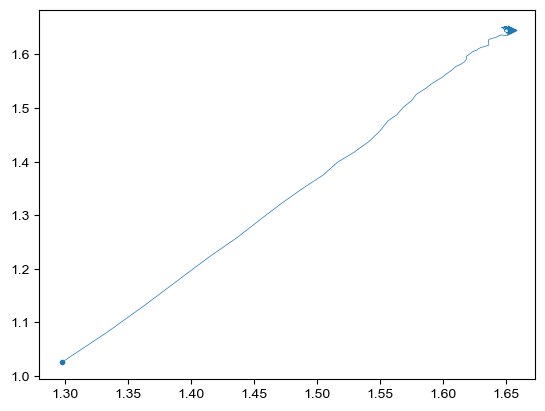

In [16]:
plt.plot(np.exp(logPara_histories_rev_delta_mean),np.exp(logPara_histories_rev_power_mean), linewidth = 0.5, color = palette[0])
plt.scatter(np.exp(logPara_histories_rev_delta_mean.head(1)),np.exp(logPara_histories_rev_power_mean.head(1)), marker = '.', color = palette[0])
plt.scatter(np.exp(logPara_histories_rev_delta_mean.tail(1)),np.exp(logPara_histories_rev_power_mean.tail(1)), marker = '>', color = palette[0])
plt.show()

In [17]:
survival_simulation_counts = pd.DataFrame()
for i in tqdm(range(revo_num+1),leave=False):
    survival_simulation_count_tmp = sim_num - np.sum(np.isnan(logPara_histories.loc[i]))/2
    survival_simulation_counts = pd.concat([survival_simulation_counts, pd.DataFrame([survival_simulation_count_tmp], index = [i], columns = ['Survivors'])], axis=0)

  0%|          | 0/101 [00:00<?, ?it/s]

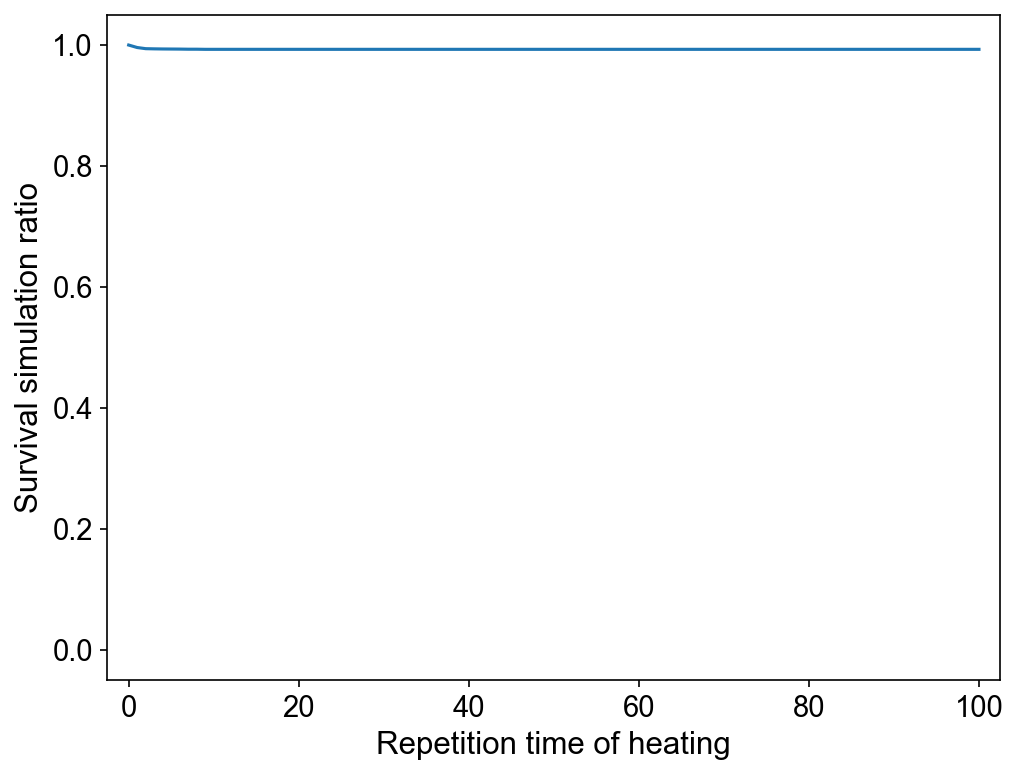

In [18]:
plt.figure(figsize=[6.4*1.2, 4.8*1.2], dpi=150)
plt.rcParams["font.family"] = "Arial"
plt.ylabel("Survival simulation ratio",size=15,fontname="Arial")
plt.xlabel("Repetition time of heating",size=15,fontname="Arial")
plt.plot(range(revo_num+1),survival_simulation_counts/sim_num, color = palette[0])
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,revo_num+2.5])
plt.savefig("Evo_Fig/Rev_1 simulation counts.pdf", bbox_inches="tight", dpi=150)
plt.show()

In [19]:
survival_simulation_counts

Survivors
0      10000.0
1       9959.0
2       9940.0
3       9937.0
4       9935.0
..         ...
96      9929.0
97      9929.0
98      9929.0
99      9929.0
100     9929.0

[101 rows x 1 columns]

In [20]:
Survival_simulation_ratio_rev = survival_simulation_counts/sim_num

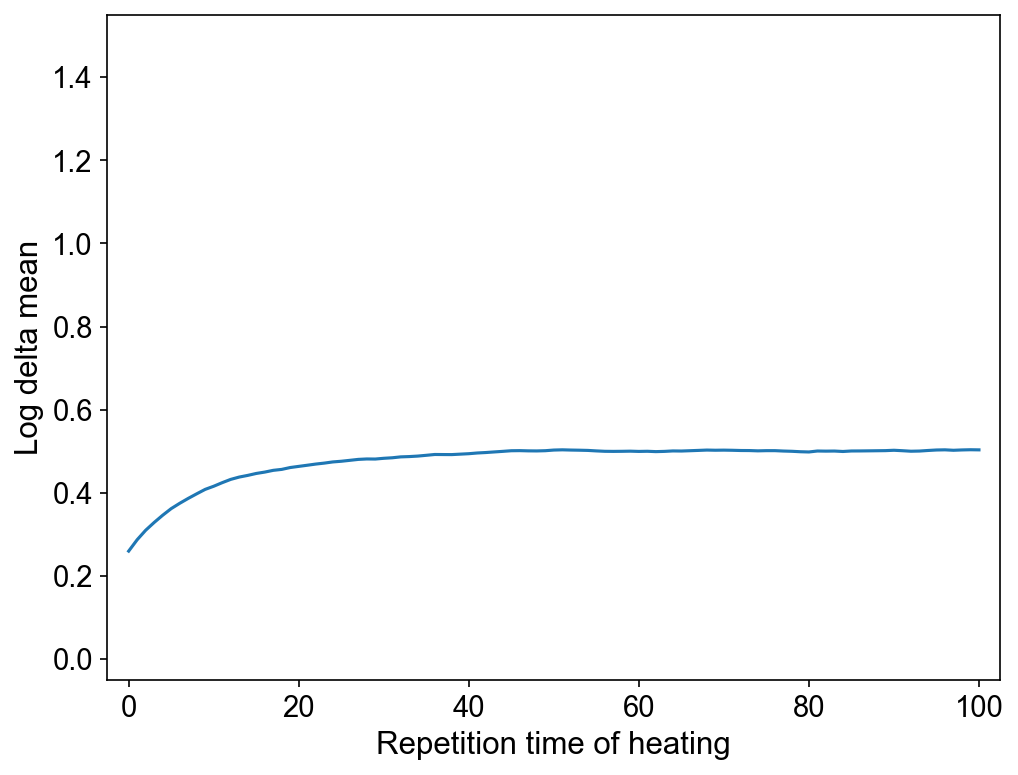

In [21]:
plt.figure(figsize=[6.4*1.2, 4.8*1.2], dpi=150)
plt.rcParams["font.family"] = "Arial"
plt.ylabel("Log delta mean",size=15,fontname="Arial")
plt.xlabel("Repetition time of heating",size=15,fontname="Arial")
plt.plot(range(revo_num+1),logPara_histories_rev_delta_mean, color = palette[0])
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([-0.05,1.55])
plt.xlim([-2.5,revo_num+2.5])
plt.savefig("Evo_Fig/Rev_1_delta_mean.pdf", bbox_inches="tight", dpi=150)
plt.show()

In [22]:
t_heating = 4*delta0_mean
warnings.simplefilter('ignore', RuntimeWarning)
Sim_results =[]
ns = range(sim_num)
with ProcessPoolExecutor(processor_num) as e:
    ret = e.map(heat_rev, ns)
logPara_histories = [r for r in ret]
logPara_histories = pd.concat(logPara_histories, axis=1)

In [23]:
logPara_histories

logdelta 0  logpower 0  logdelta 1  logpower 1  logdelta 2  logpower 2  \
0      0.302447    0.431105     0.22697   -0.231822    0.417707    0.036302   
1      0.344000    0.592900     0.27850   -0.356600    0.620200   -0.119500   
2      0.418100    0.581600         NaN         NaN    0.569400   -0.067900   
3      0.357800    0.518000         NaN         NaN    0.656100   -0.185700   
4      0.456700    0.523000         NaN         NaN    0.692800    0.062600   
..          ...         ...         ...         ...         ...         ...   
96     0.467500    0.956300         NaN         NaN    0.891500    0.956400   
97     0.467500    0.956300         NaN         NaN    1.011800    0.894300   
98     0.408900    1.129600         NaN         NaN    1.011800    0.894300   
99     0.473700    1.128500         NaN         NaN    1.011800    0.894300   
100    0.537000    1.120400         NaN         NaN    0.846300    0.955800   

     logdelta 3  logpower 3  logdelta 4  logpower 4  ...  logdelta 9995  \
0      0.030729    0.015013    0.396423    0.235764  ...       0.263001   
1           NaN         NaN    0.396400    0.235800  ...       0.433200   
2           NaN         NaN    0.396400    0.235800  ...       0.299100   
3           NaN         NaN    0.515500    0.164000  ...       0.269600   
4           NaN         NaN    0.405100    0.278600  ...       0.287100   
..          ...         ...         ...         ...  ...            ...   
96          NaN         NaN    0.734700    0.878400  ...       0.519200   
97          NaN         NaN    0.669300    0.788000  ...       0.519200   
98          NaN         NaN    0.442300    0.853100  ...       0.519200   
99          NaN         NaN    0.542000    0.782600  ...       0.511600   
100         NaN         NaN    0.618900    0.642900  ...       0.560600   

     logpower 9995  logdelta 9996  logpower 9996  logdelta 9997  \
0         0.220955       0.108068       0.283268       0.085549   
1         0.138700       0.196500       0.447600            NaN   
2         0.183000       0.360400       0.507300            NaN   
3         0.153300       0.614400       0.436700            NaN   
4         0.308300       0.486600       0.523400            NaN   
..             ...            ...            ...            ...   
96        0.988200       0.968600       0.558900            NaN   
97        0.988200       0.739200       0.834000            NaN   
98        0.988200       0.739200       0.834000            NaN   
99        0.949800       0.703200       1.009700            NaN   
100       0.980000       0.667300       1.042400            NaN   

     logpower 9997  logdelta 9998  logpower 9998  logdelta 9999  logpower 9999  
0        -0.182882       0.632158       0.487543       0.287387      -0.254249  
1              NaN       0.743400       0.480200       0.374800      -0.153100  
2              NaN       0.733000       0.436400            NaN            NaN  
3              NaN       0.761200       0.365600            NaN            NaN  
4              NaN       0.761200       0.365600            NaN            NaN  
..             ...            ...            ...            ...            ...  
96             NaN       0.949400       0.669900            NaN            NaN  
97             NaN       0.877600       0.814000            NaN            NaN  
98             NaN       0.649800       1.094600            NaN            NaN  
99             NaN       0.673300       1.174700            NaN            NaN  
100            NaN       0.727000       0.976200            NaN            NaN  

[101 rows x 20000 columns]

palette = sns.color_palette(n_colors = sim_num)
for j in tqdm(range(sim_num),leave=False):
    plt.plot(logPara_histories['logdelta '+str(j)],logPara_histories['logpower '+str(j)], linewidth = 0.5, color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    plt.scatter(logPara_histories['logdelta '+str(j)].head(1),logPara_histories['logpower '+str(j)].head(1), marker = '.', color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    if np.isnan(logPara_histories['logdelta '+str(j)].tail(1).iloc[0]):
        plt.scatter(logPara_histories['logdelta '+str(j)].dropna(how='all', axis=0).tail(1),logPara_histories['logpower '+str(j)].dropna(how='all', axis=0).tail(1), marker = 'x', color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    if logPara_histories['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(logPara_histories['logdelta '+str(j)].tail(1),logPara_histories['logpower '+str(j)].tail(1), marker = '>', color = palette[j], alpha=0.1)
plt.show()

palette = sns.color_palette(n_colors = sim_num)
for j in tqdm(range(sim_num),leave=False):
    plt.plot(np.exp(logPara_histories['logdelta '+str(j)]),np.exp(logPara_histories['logpower '+str(j)]), linewidth = 0.5, color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].head(1)),np.exp(logPara_histories['logpower '+str(j)].head(1)), marker = '.', color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    if np.isnan(logPara_histories['logdelta '+str(j)].tail(1).iloc[0]):
        plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].dropna(how='all', axis=0).tail(1)),np.exp(logPara_histories['logpower '+str(j)].dropna(how='all', axis=0).tail(1)), marker = 'x', color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    if logPara_histories['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].tail(1)),np.exp(logPara_histories['logpower '+str(j)].tail(1)), marker = '>', color = palette[j], alpha=0.1)
plt.show()

In [24]:
with open('Simulated revolution_2.pkl', 'wb') as g:
    pickle.dump(logPara_histories, g)

In [25]:
logPara_histories_rev_2 = logPara_histories

In [26]:
logPara_histories_rev_2

logdelta 0  logpower 0  logdelta 1  logpower 1  logdelta 2  logpower 2  \
0      0.302447    0.431105     0.22697   -0.231822    0.417707    0.036302   
1      0.344000    0.592900     0.27850   -0.356600    0.620200   -0.119500   
2      0.418100    0.581600         NaN         NaN    0.569400   -0.067900   
3      0.357800    0.518000         NaN         NaN    0.656100   -0.185700   
4      0.456700    0.523000         NaN         NaN    0.692800    0.062600   
..          ...         ...         ...         ...         ...         ...   
96     0.467500    0.956300         NaN         NaN    0.891500    0.956400   
97     0.467500    0.956300         NaN         NaN    1.011800    0.894300   
98     0.408900    1.129600         NaN         NaN    1.011800    0.894300   
99     0.473700    1.128500         NaN         NaN    1.011800    0.894300   
100    0.537000    1.120400         NaN         NaN    0.846300    0.955800   

     logdelta 3  logpower 3  logdelta 4  logpower 4  ...  logdelta 9995  \
0      0.030729    0.015013    0.396423    0.235764  ...       0.263001   
1           NaN         NaN    0.396400    0.235800  ...       0.433200   
2           NaN         NaN    0.396400    0.235800  ...       0.299100   
3           NaN         NaN    0.515500    0.164000  ...       0.269600   
4           NaN         NaN    0.405100    0.278600  ...       0.287100   
..          ...         ...         ...         ...  ...            ...   
96          NaN         NaN    0.734700    0.878400  ...       0.519200   
97          NaN         NaN    0.669300    0.788000  ...       0.519200   
98          NaN         NaN    0.442300    0.853100  ...       0.519200   
99          NaN         NaN    0.542000    0.782600  ...       0.511600   
100         NaN         NaN    0.618900    0.642900  ...       0.560600   

     logpower 9995  logdelta 9996  logpower 9996  logdelta 9997  \
0         0.220955       0.108068       0.283268       0.085549   
1         0.138700       0.196500       0.447600            NaN   
2         0.183000       0.360400       0.507300            NaN   
3         0.153300       0.614400       0.436700            NaN   
4         0.308300       0.486600       0.523400            NaN   
..             ...            ...            ...            ...   
96        0.988200       0.968600       0.558900            NaN   
97        0.988200       0.739200       0.834000            NaN   
98        0.988200       0.739200       0.834000            NaN   
99        0.949800       0.703200       1.009700            NaN   
100       0.980000       0.667300       1.042400            NaN   

     logpower 9997  logdelta 9998  logpower 9998  logdelta 9999  logpower 9999  
0        -0.182882       0.632158       0.487543       0.287387      -0.254249  
1              NaN       0.743400       0.480200       0.374800      -0.153100  
2              NaN       0.733000       0.436400            NaN            NaN  
3              NaN       0.761200       0.365600            NaN            NaN  
4              NaN       0.761200       0.365600            NaN            NaN  
..             ...            ...            ...            ...            ...  
96             NaN       0.949400       0.669900            NaN            NaN  
97             NaN       0.877600       0.814000            NaN            NaN  
98             NaN       0.649800       1.094600            NaN            NaN  
99             NaN       0.673300       1.174700            NaN            NaN  
100            NaN       0.727000       0.976200            NaN            NaN  

[101 rows x 20000 columns]

In [27]:
logPara_histories.dropna(axis=1)

logdelta 0  logpower 0  logdelta 2  logpower 2  logdelta 4  logpower 4  \
0      0.302447    0.431105    0.417707    0.036302    0.396423    0.235764   
1      0.344000    0.592900    0.620200   -0.119500    0.396400    0.235800   
2      0.418100    0.581600    0.569400   -0.067900    0.396400    0.235800   
3      0.357800    0.518000    0.656100   -0.185700    0.515500    0.164000   
4      0.456700    0.523000    0.692800    0.062600    0.405100    0.278600   
..          ...         ...         ...         ...         ...         ...   
96     0.467500    0.956300    0.891500    0.956400    0.734700    0.878400   
97     0.467500    0.956300    1.011800    0.894300    0.669300    0.788000   
98     0.408900    1.129600    1.011800    0.894300    0.442300    0.853100   
99     0.473700    1.128500    1.011800    0.894300    0.542000    0.782600   
100    0.537000    1.120400    0.846300    0.955800    0.618900    0.642900   

     logdelta 5  logpower 5  logdelta 7  logpower 7  ...  logdelta 9991  \
0       0.25996    0.050755    0.644256     0.02494  ...       0.599621   
1       0.42610    0.298100    0.699100     0.07930  ...       0.599600   
2       0.52350    0.292900    0.843900     0.09610  ...       0.599600   
3       0.46930    0.601700    0.785200     0.31860  ...       0.606200   
4       0.41770    0.641300    0.785200     0.31860  ...       0.553200   
..          ...         ...         ...         ...  ...            ...   
96      0.94990    0.365500    0.913700     0.42270  ...       0.309600   
97      0.94990    0.365500    0.913700     0.42270  ...       0.190300   
98      0.94990    0.365500    0.913700     0.42270  ...       0.302400   
99      0.94990    0.365500    0.950800     0.30100  ...       0.191600   
100     1.09900    0.356300    0.932200     0.33300  ...       0.191600   

     logpower 9991  logdelta 9993  logpower 9993  logdelta 9995  \
0         0.011951       0.336196       0.208927       0.263001   
1         0.012000       0.338700       0.298300       0.433200   
2         0.012000       0.357100       0.346800       0.299100   
3         0.269400       0.580700       0.323300       0.269600   
4         0.354600       0.580700       0.323300       0.287100   
..             ...            ...            ...            ...   
96        0.751300       0.948200       0.701200       0.519200   
97        0.677600       0.996200       0.730300       0.519200   
98        0.577500       0.996200       0.730300       0.519200   
99        0.578400       0.996200       0.730300       0.511600   
100       0.578400       0.944000       0.655400       0.560600   

     logpower 9995  logdelta 9996  logpower 9996  logdelta 9998  logpower 9998  
0         0.220955       0.108068       0.283268       0.632158       0.487543  
1         0.138700       0.196500       0.447600       0.743400       0.480200  
2         0.183000       0.360400       0.507300       0.733000       0.436400  
3         0.153300       0.614400       0.436700       0.761200       0.365600  
4         0.308300       0.486600       0.523400       0.761200       0.365600  
..             ...            ...            ...            ...            ...  
96        0.988200       0.968600       0.558900       0.949400       0.669900  
97        0.988200       0.739200       0.834000       0.877600       0.814000  
98        0.988200       0.739200       0.834000       0.649800       1.094600  
99        0.949800       0.703200       1.009700       0.673300       1.174700  
100       0.980000       0.667300       1.042400       0.727000       0.976200  

[101 rows x 10396 columns]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

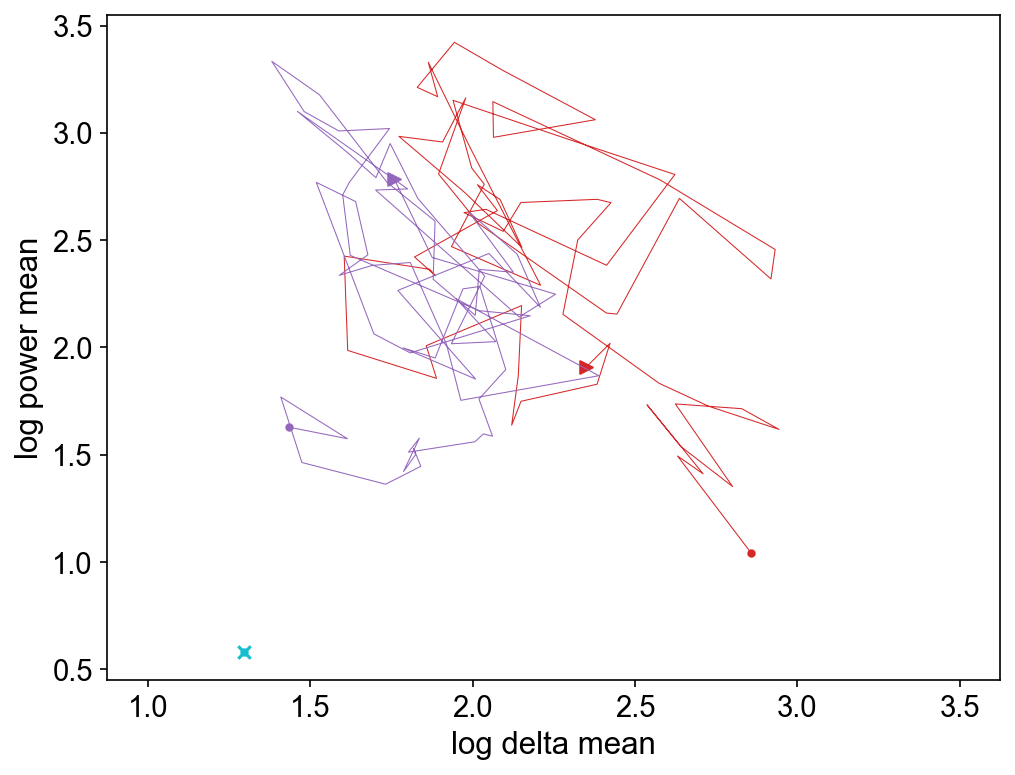

In [28]:
plt.figure(figsize=[6.4*1.2, 4.8*1.2], dpi=150)
plt.rcParams["font.family"] = "Arial"
plt.xlabel("log delta mean",size=15,fontname="Arial")
plt.ylabel("log power mean",size=15,fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim([1.0-0.125,3.5+0.125])
plt.ylim([0.5-0.05,3.5+0.05])

palette = sns.color_palette(n_colors = sim_num)
watch_list = [153, 309, 344]
for j in tqdm(watch_list,leave=False):
    plt.plot(np.exp(logPara_histories['logdelta '+str(j)]),np.exp(logPara_histories['logpower '+str(j)]), linewidth = 0.5, color = palette[j])

for j in tqdm(watch_list,leave=False):
    plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].head(1)),np.exp(logPara_histories['logpower '+str(j)].head(1)), marker = '.', color = palette[j])

for j in tqdm(watch_list,leave=False):
    if np.isnan(logPara_histories['logdelta '+str(j)].tail(1).iloc[0]):
        plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].dropna(how='all', axis=0).tail(1)),np.exp(logPara_histories['logpower '+str(j)].dropna(how='all', axis=0).tail(1)), marker = 'x', color = palette[j])

for j in tqdm(watch_list,leave=False):
    if logPara_histories['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].tail(1)),np.exp(logPara_histories['logpower '+str(j)].tail(1)), marker = '>', color = palette[j])

plt.savefig("Evo_Fig/Rev_2 simulated parameters.pdf", bbox_inches="tight", dpi=150)
plt.show()

In [29]:
logPara_histories_rev_2_delta = logPara_histories_rev_2[logPara_histories_rev_2.columns[logPara_histories_rev_2.columns.str.startswith("logdelta")]]
logPara_histories_rev_2_delta

logdelta 0  logdelta 1  logdelta 2  logdelta 3  logdelta 4  logdelta 5  \
0      0.302447     0.22697    0.417707    0.030729    0.396423     0.25996   
1      0.344000     0.27850    0.620200         NaN    0.396400     0.42610   
2      0.418100         NaN    0.569400         NaN    0.396400     0.52350   
3      0.357800         NaN    0.656100         NaN    0.515500     0.46930   
4      0.456700         NaN    0.692800         NaN    0.405100     0.41770   
..          ...         ...         ...         ...         ...         ...   
96     0.467500         NaN    0.891500         NaN    0.734700     0.94990   
97     0.467500         NaN    1.011800         NaN    0.669300     0.94990   
98     0.408900         NaN    1.011800         NaN    0.442300     0.94990   
99     0.473700         NaN    1.011800         NaN    0.542000     0.94990   
100    0.537000         NaN    0.846300         NaN    0.618900     1.09900   

     logdelta 6  logdelta 7  logdelta 8  logdelta 9  ...  logdelta 9990  \
0      0.214055    0.644256    0.085749     1.06891  ...       0.329878   
1           NaN    0.699100    0.116000         NaN  ...       0.218400   
2           NaN    0.843900    0.177200         NaN  ...       0.361100   
3           NaN    0.785200    0.342900         NaN  ...       0.399800   
4           NaN    0.785200    0.301500         NaN  ...       0.477700   
..          ...         ...         ...         ...  ...            ...   
96          NaN    0.913700    0.787500         NaN  ...       0.647600   
97          NaN    0.913700    0.802900         NaN  ...       0.647600   
98          NaN    0.913700    0.802900         NaN  ...       0.647600   
99          NaN    0.950800    0.790500         NaN  ...       0.647600   
100         NaN    0.932200    0.790500         NaN  ...       0.497100   

     logdelta 9991  logdelta 9992  logdelta 9993  logdelta 9994  \
0         0.599621       0.184801       0.336196       0.206605   
1         0.599600            NaN       0.338700       0.197500   
2         0.599600            NaN       0.357100            NaN   
3         0.606200            NaN       0.580700            NaN   
4         0.553200            NaN       0.580700            NaN   
..             ...            ...            ...            ...   
96        0.309600            NaN       0.948200            NaN   
97        0.190300            NaN       0.996200            NaN   
98        0.302400            NaN       0.996200            NaN   
99        0.191600            NaN       0.996200            NaN   
100       0.191600            NaN       0.944000            NaN   

     logdelta 9995  logdelta 9996  logdelta 9997  logdelta 9998  logdelta 9999  
0         0.263001       0.108068       0.085549       0.632158       0.287387  
1         0.433200       0.196500            NaN       0.743400       0.374800  
2         0.299100       0.360400            NaN       0.733000            NaN  
3         0.269600       0.614400            NaN       0.761200            NaN  
4         0.287100       0.486600            NaN       0.761200            NaN  
..             ...            ...            ...            ...            ...  
96        0.519200       0.968600            NaN       0.949400            NaN  
97        0.519200       0.739200            NaN       0.877600            NaN  
98        0.519200       0.739200            NaN       0.649800            NaN  
99        0.511600       0.703200            NaN       0.673300            NaN  
100       0.560600       0.667300            NaN       0.727000            NaN  

[101 rows x 10000 columns]

In [30]:
logPara_histories_rev_2_power = logPara_histories_rev_2[logPara_histories_rev_2.columns[logPara_histories_rev_2.columns.str.startswith("logpower")]]
logPara_histories_rev_2_power

logpower 0  logpower 1  logpower 2  logpower 3  logpower 4  logpower 5  \
0      0.431105   -0.231822    0.036302    0.015013    0.235764    0.050755   
1      0.592900   -0.356600   -0.119500         NaN    0.235800    0.298100   
2      0.581600         NaN   -0.067900         NaN    0.235800    0.292900   
3      0.518000         NaN   -0.185700         NaN    0.164000    0.601700   
4      0.523000         NaN    0.062600         NaN    0.278600    0.641300   
..          ...         ...         ...         ...         ...         ...   
96     0.956300         NaN    0.956400         NaN    0.878400    0.365500   
97     0.956300         NaN    0.894300         NaN    0.788000    0.365500   
98     1.129600         NaN    0.894300         NaN    0.853100    0.365500   
99     1.128500         NaN    0.894300         NaN    0.782600    0.365500   
100    1.120400         NaN    0.955800         NaN    0.642900    0.356300   

     logpower 6  logpower 7  logpower 8  logpower 9  ...  logpower 9990  \
0     -0.070829     0.02494     0.25295   -1.165343  ...       0.027758   
1           NaN     0.07930     0.20690         NaN  ...       0.114600   
2           NaN     0.09610     0.29180         NaN  ...      -0.105500   
3           NaN     0.31860     0.32200         NaN  ...       0.010400   
4           NaN     0.31860     0.42970         NaN  ...       0.018300   
..          ...         ...         ...         ...  ...            ...   
96          NaN     0.42270     0.55840         NaN  ...       0.936600   
97          NaN     0.42270     0.57560         NaN  ...       0.936600   
98          NaN     0.42270     0.57560         NaN  ...       0.936600   
99          NaN     0.30100     0.58720         NaN  ...       0.936600   
100         NaN     0.33300     0.58720         NaN  ...       0.985600   

     logpower 9991  logpower 9992  logpower 9993  logpower 9994  \
0         0.011951       0.133718       0.208927      -0.107732   
1         0.012000            NaN       0.298300      -0.107300   
2         0.012000            NaN       0.346800            NaN   
3         0.269400            NaN       0.323300            NaN   
4         0.354600            NaN       0.323300            NaN   
..             ...            ...            ...            ...   
96        0.751300            NaN       0.701200            NaN   
97        0.677600            NaN       0.730300            NaN   
98        0.577500            NaN       0.730300            NaN   
99        0.578400            NaN       0.730300            NaN   
100       0.578400            NaN       0.655400            NaN   

     logpower 9995  logpower 9996  logpower 9997  logpower 9998  logpower 9999  
0         0.220955       0.283268      -0.182882       0.487543      -0.254249  
1         0.138700       0.447600            NaN       0.480200      -0.153100  
2         0.183000       0.507300            NaN       0.436400            NaN  
3         0.153300       0.436700            NaN       0.365600            NaN  
4         0.308300       0.523400            NaN       0.365600            NaN  
..             ...            ...            ...            ...            ...  
96        0.988200       0.558900            NaN       0.669900            NaN  
97        0.988200       0.834000            NaN       0.814000            NaN  
98        0.988200       0.834000            NaN       1.094600            NaN  
99        0.949800       1.009700            NaN       1.174700            NaN  
100       0.980000       1.042400            NaN       0.976200            NaN  

[101 rows x 10000 columns]

In [31]:
logPara_histories_rev_2_delta_mean = logPara_histories_rev_2_delta.mean(axis=1)
logPara_histories_rev_2_power_mean = logPara_histories_rev_2_power.mean(axis=1)

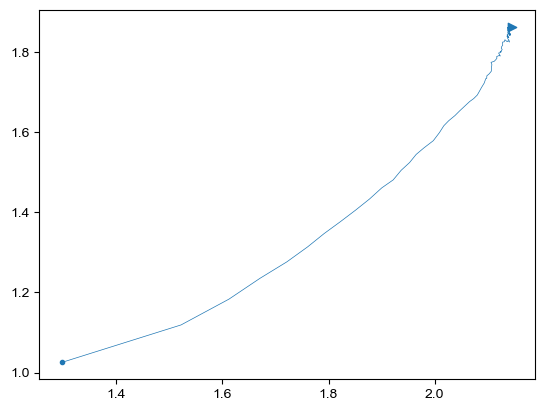

In [32]:
plt.plot(np.exp(logPara_histories_rev_2_delta_mean),np.exp(logPara_histories_rev_2_power_mean), linewidth = 0.5, color = palette[0])
plt.scatter(np.exp(logPara_histories_rev_2_delta_mean.head(1)),np.exp(logPara_histories_rev_2_power_mean.head(1)), marker = '.', color = palette[0])
plt.scatter(np.exp(logPara_histories_rev_2_delta_mean.tail(1)),np.exp(logPara_histories_rev_2_power_mean.tail(1)), marker = '>', color = palette[0])
plt.show()

In [33]:
survival_simulation_counts = pd.DataFrame()
for i in tqdm(range(revo_num+1),leave=False):
    survival_simulation_count_tmp = sim_num - np.sum(np.isnan(logPara_histories.loc[i]))/2
    survival_simulation_counts = pd.concat([survival_simulation_counts, pd.DataFrame([survival_simulation_count_tmp], index = [i], columns = ['Survivors'])], axis=0)

  0%|          | 0/101 [00:00<?, ?it/s]

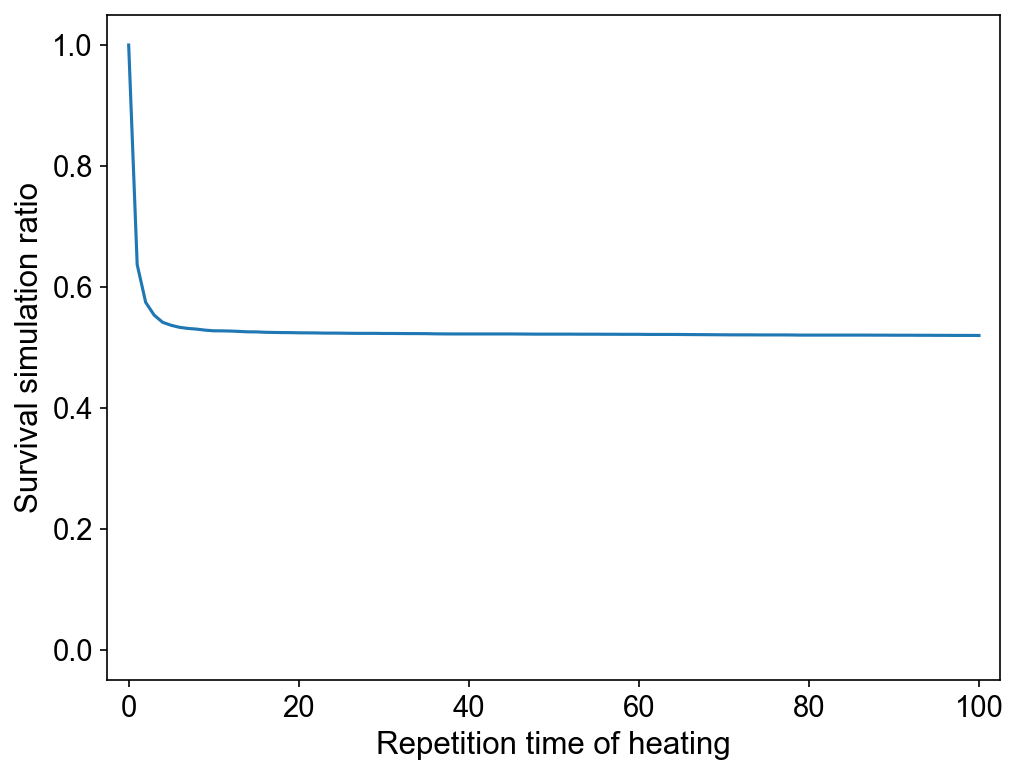

In [34]:

plt.figure(figsize=[6.4*1.2, 4.8*1.2], dpi=150)
plt.rcParams["font.family"] = "Arial"
plt.ylabel("Survival simulation ratio",size=15,fontname="Arial")
plt.xlabel("Repetition time of heating",size=15,fontname="Arial")
plt.plot(range(revo_num+1),survival_simulation_counts/sim_num, color = palette[0])
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,revo_num+2.5])
plt.savefig("Evo_Fig/Rev_2 simulation counts.pdf", bbox_inches="tight", dpi=150)
plt.show()

In [35]:
survival_simulation_counts

Survivors
0      10000.0
1       6370.0
2       5746.0
3       5534.0
4       5415.0
..         ...
96      5200.0
97      5199.0
98      5199.0
99      5199.0
100     5198.0

[101 rows x 1 columns]

In [36]:
Survival_simulation_ratio_rev_2 = survival_simulation_counts/sim_num

In [37]:
t_heating = 6*delta0_mean
warnings.simplefilter('ignore', RuntimeWarning)
Sim_results =[]
ns = range(sim_num)
with ProcessPoolExecutor(processor_num) as e:
    ret = e.map(heat_rev, ns)
logPara_histories = [r for r in ret]
logPara_histories = pd.concat(logPara_histories, axis=1)

In [38]:
logPara_histories

logdelta 0  logpower 0  logdelta 1  logpower 1  logdelta 2  logpower 2  \
0      0.302447    0.431105     0.22697   -0.231822    0.417707    0.036302   
1      0.338600    0.448700         NaN         NaN         NaN         NaN   
2           NaN         NaN         NaN         NaN         NaN         NaN   
3           NaN         NaN         NaN         NaN         NaN         NaN   
4           NaN         NaN         NaN         NaN         NaN         NaN   
..          ...         ...         ...         ...         ...         ...   
96          NaN         NaN         NaN         NaN         NaN         NaN   
97          NaN         NaN         NaN         NaN         NaN         NaN   
98          NaN         NaN         NaN         NaN         NaN         NaN   
99          NaN         NaN         NaN         NaN         NaN         NaN   
100         NaN         NaN         NaN         NaN         NaN         NaN   

     logdelta 3  logpower 3  logdelta 4  logpower 4  ...  logdelta 9995  \
0      0.030729    0.015013    0.396423    0.235764  ...       0.263001   
1           NaN         NaN    0.500300    0.365000  ...            NaN   
2           NaN         NaN         NaN         NaN  ...            NaN   
3           NaN         NaN         NaN         NaN  ...            NaN   
4           NaN         NaN         NaN         NaN  ...            NaN   
..          ...         ...         ...         ...  ...            ...   
96          NaN         NaN         NaN         NaN  ...            NaN   
97          NaN         NaN         NaN         NaN  ...            NaN   
98          NaN         NaN         NaN         NaN  ...            NaN   
99          NaN         NaN         NaN         NaN  ...            NaN   
100         NaN         NaN         NaN         NaN  ...            NaN   

     logpower 9995  logdelta 9996  logpower 9996  logdelta 9997  \
0         0.220955       0.108068       0.283268       0.085549   
1              NaN            NaN            NaN            NaN   
2              NaN            NaN            NaN            NaN   
3              NaN            NaN            NaN            NaN   
4              NaN            NaN            NaN            NaN   
..             ...            ...            ...            ...   
96             NaN            NaN            NaN            NaN   
97             NaN            NaN            NaN            NaN   
98             NaN            NaN            NaN            NaN   
99             NaN            NaN            NaN            NaN   
100            NaN            NaN            NaN            NaN   

     logpower 9997  logdelta 9998  logpower 9998  logdelta 9999  logpower 9999  
0        -0.182882       0.632158       0.487543       0.287387      -0.254249  
1              NaN       0.632200       0.487500            NaN            NaN  
2              NaN       0.611000       0.537700            NaN            NaN  
3              NaN       0.709200       0.656200            NaN            NaN  
4              NaN       0.709200       0.656200            NaN            NaN  
..             ...            ...            ...            ...            ...  
96             NaN       1.001300       0.677800            NaN            NaN  
97             NaN       1.001300       0.677800            NaN            NaN  
98             NaN       0.969300       0.683600            NaN            NaN  
99             NaN       0.969300       0.683600            NaN            NaN  
100            NaN       0.860200       0.796700            NaN            NaN  

[101 rows x 20000 columns]

palette = sns.color_palette(n_colors = sim_num)
for j in tqdm(range(sim_num),leave=False):
    plt.plot(logPara_histories['logdelta '+str(j)],logPara_histories['logpower '+str(j)], linewidth = 0.5, color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    plt.scatter(logPara_histories['logdelta '+str(j)].head(1),logPara_histories['logpower '+str(j)].head(1), marker = '.', color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    if np.isnan(logPara_histories['logdelta '+str(j)].tail(1).iloc[0]):
        plt.scatter(logPara_histories['logdelta '+str(j)].dropna(how='all', axis=0).tail(1),logPara_histories['logpower '+str(j)].dropna(how='all', axis=0).tail(1), marker = 'x', color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    if logPara_histories['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(logPara_histories['logdelta '+str(j)].tail(1),logPara_histories['logpower '+str(j)].tail(1), marker = '>', color = palette[j], alpha=0.1)
plt.show()

palette = sns.color_palette(n_colors = sim_num)
for j in tqdm(range(sim_num),leave=False):
    plt.plot(np.exp(logPara_histories['logdelta '+str(j)]),np.exp(logPara_histories['logpower '+str(j)]), linewidth = 0.5, color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].head(1)),np.exp(logPara_histories['logpower '+str(j)].head(1)), marker = '.', color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    if np.isnan(logPara_histories['logdelta '+str(j)].tail(1).iloc[0]):
        plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].dropna(how='all', axis=0).tail(1)),np.exp(logPara_histories['logpower '+str(j)].dropna(how='all', axis=0).tail(1)), marker = 'x', color = palette[j], alpha=0.1)

for j in tqdm(range(sim_num),leave=False):
    if logPara_histories['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].tail(1)),np.exp(logPara_histories['logpower '+str(j)].tail(1)), marker = '>', color = palette[j], alpha=0.1)
plt.show()

In [39]:
with open('Simulated revolution_3.pkl', 'wb') as g:
    pickle.dump(logPara_histories, g)

In [40]:
logPara_histories_rev_3 = logPara_histories

In [41]:
logPara_histories_rev_3

logdelta 0  logpower 0  logdelta 1  logpower 1  logdelta 2  logpower 2  \
0      0.302447    0.431105     0.22697   -0.231822    0.417707    0.036302   
1      0.338600    0.448700         NaN         NaN         NaN         NaN   
2           NaN         NaN         NaN         NaN         NaN         NaN   
3           NaN         NaN         NaN         NaN         NaN         NaN   
4           NaN         NaN         NaN         NaN         NaN         NaN   
..          ...         ...         ...         ...         ...         ...   
96          NaN         NaN         NaN         NaN         NaN         NaN   
97          NaN         NaN         NaN         NaN         NaN         NaN   
98          NaN         NaN         NaN         NaN         NaN         NaN   
99          NaN         NaN         NaN         NaN         NaN         NaN   
100         NaN         NaN         NaN         NaN         NaN         NaN   

     logdelta 3  logpower 3  logdelta 4  logpower 4  ...  logdelta 9995  \
0      0.030729    0.015013    0.396423    0.235764  ...       0.263001   
1           NaN         NaN    0.500300    0.365000  ...            NaN   
2           NaN         NaN         NaN         NaN  ...            NaN   
3           NaN         NaN         NaN         NaN  ...            NaN   
4           NaN         NaN         NaN         NaN  ...            NaN   
..          ...         ...         ...         ...  ...            ...   
96          NaN         NaN         NaN         NaN  ...            NaN   
97          NaN         NaN         NaN         NaN  ...            NaN   
98          NaN         NaN         NaN         NaN  ...            NaN   
99          NaN         NaN         NaN         NaN  ...            NaN   
100         NaN         NaN         NaN         NaN  ...            NaN   

     logpower 9995  logdelta 9996  logpower 9996  logdelta 9997  \
0         0.220955       0.108068       0.283268       0.085549   
1              NaN            NaN            NaN            NaN   
2              NaN            NaN            NaN            NaN   
3              NaN            NaN            NaN            NaN   
4              NaN            NaN            NaN            NaN   
..             ...            ...            ...            ...   
96             NaN            NaN            NaN            NaN   
97             NaN            NaN            NaN            NaN   
98             NaN            NaN            NaN            NaN   
99             NaN            NaN            NaN            NaN   
100            NaN            NaN            NaN            NaN   

     logpower 9997  logdelta 9998  logpower 9998  logdelta 9999  logpower 9999  
0        -0.182882       0.632158       0.487543       0.287387      -0.254249  
1              NaN       0.632200       0.487500            NaN            NaN  
2              NaN       0.611000       0.537700            NaN            NaN  
3              NaN       0.709200       0.656200            NaN            NaN  
4              NaN       0.709200       0.656200            NaN            NaN  
..             ...            ...            ...            ...            ...  
96             NaN       1.001300       0.677800            NaN            NaN  
97             NaN       1.001300       0.677800            NaN            NaN  
98             NaN       0.969300       0.683600            NaN            NaN  
99             NaN       0.969300       0.683600            NaN            NaN  
100            NaN       0.860200       0.796700            NaN            NaN  

[101 rows x 20000 columns]

In [42]:
logPara_histories.dropna(axis=1)

logdelta 26  logpower 26  logdelta 61  logpower 61  logdelta 62  \
0       0.634444     0.094813     1.029963     -0.12611     1.001272   
1       0.634400     0.094800     1.143200     -0.13670     1.017700   
2       0.634400     0.094800     1.265100     -0.23910     1.017700   
3       0.847600     0.175700     1.265100     -0.23910     0.922600   
4       0.847600     0.175700     1.265100     -0.23910     0.922600   
..           ...          ...          ...          ...          ...   
96      0.810600    -0.078700     0.704000      0.96120     1.223300   
97      0.810600    -0.078700     0.757700      0.85500     1.026700   
98      0.917800    -0.142000     0.757700      0.85500     0.976800   
99      0.925700    -0.221800     0.683500      0.99840     0.976800   
100     0.925700    -0.221800     0.683500      0.99840     0.976800   

     logpower 62  logdelta 64  logpower 64  logdelta 80  logpower 80  ...  \
0      -0.285358     0.699082     0.085666     0.672606     0.245019  ...   
1      -0.143000     0.808300     0.203200     0.868300     0.177000  ...   
2      -0.143000     0.902900     0.292600     0.955500     0.011900  ...   
3      -0.145100     0.862900     0.352300     0.955500     0.011900  ...   
4      -0.145100     0.754900     0.337100     0.955500     0.011900  ...   
..           ...          ...          ...          ...          ...  ...   
96      0.903600     0.980400     0.614300     1.148000     0.507400  ...   
97      0.903300     0.980400     0.614300     1.149000     0.420900  ...   
98      0.906700     0.980400     0.614300     1.277500     0.588400  ...   
99      0.906700     0.973500     0.639800     1.277500     0.588400  ...   
100     0.906700     0.973500     0.639800     1.310800     0.792000  ...   

     logdelta 9921  logpower 9921  logdelta 9940  logpower 9940  \
0         0.486661       0.517392       0.494389       0.286631   
1         0.583600       0.560700       0.553500       0.251800   
2         0.724700       0.520200       0.599900       0.063600   
3         0.724700       0.520200       0.713800       0.353900   
4         0.685400       0.480400       0.713800       0.353900   
..             ...            ...            ...            ...   
96        1.067300       0.378500       1.038800       0.286100   
97        1.118200       0.431000       0.961000       0.505100   
98        1.118200       0.431000       0.991700       0.426200   
99        1.118200       0.431000       0.974200       0.380100   
100       1.001900       0.457600       1.055100       0.276900   

     logdelta 9948  logpower 9948  logdelta 9981  logpower 9981  \
0          0.71101       0.111064       0.685672        0.13831   
1          0.71100       0.111100       0.773300        0.07250   
2          0.49700       0.210400       0.783100        0.14210   
3          0.57080       0.410800       0.719900        0.23590   
4          0.57080       0.410800       0.808100        0.22510   
..             ...            ...            ...            ...   
96         0.84970       1.212500       0.985700        1.12040   
97         0.89210       1.140800       1.095900        1.06200   
98         0.87910       0.896200       1.095900        1.06200   
99         0.96140       0.766200       1.095900        1.06200   
100        0.99090       0.916000       1.095900        1.06200   

     logdelta 9998  logpower 9998  
0         0.632158       0.487543  
1         0.632200       0.487500  
2         0.611000       0.537700  
3         0.709200       0.656200  
4         0.709200       0.656200  
..             ...            ...  
96        1.001300       0.677800  
97        1.001300       0.677800  
98        0.969300       0.683600  
99        0.969300       0.683600  
100       0.860200       0.796700  

[101 rows x 946 columns]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

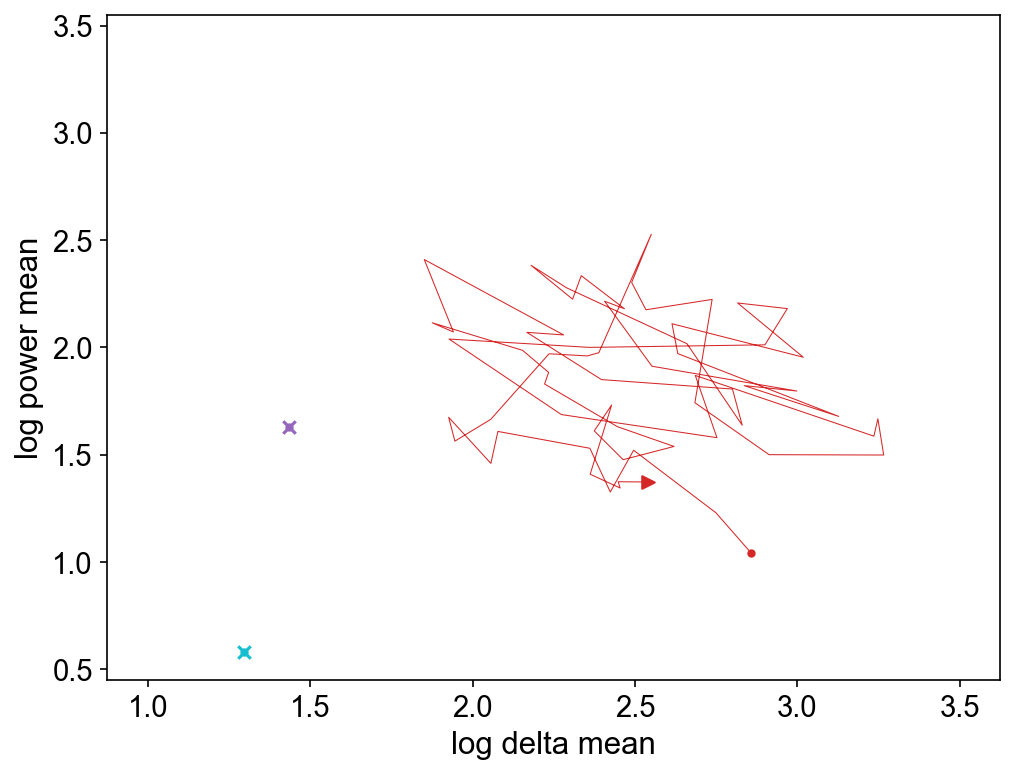

In [43]:
plt.figure(figsize=[6.4*1.2, 4.8*1.2], dpi=150)
plt.rcParams["font.family"] = "Arial"
plt.xlabel("log delta mean",size=15,fontname="Arial")
plt.ylabel("log power mean",size=15,fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim([1.0-0.125,3.5+0.125])
plt.ylim([0.5-0.05,3.5+0.05])

palette = sns.color_palette(n_colors = sim_num)
watch_list = [153, 309, 344]
for j in tqdm(watch_list,leave=False):
    plt.plot(np.exp(logPara_histories['logdelta '+str(j)]),np.exp(logPara_histories['logpower '+str(j)]), linewidth = 0.5, color = palette[j])

for j in tqdm(watch_list,leave=False):
    plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].head(1)),np.exp(logPara_histories['logpower '+str(j)].head(1)), marker = '.', color = palette[j])

for j in tqdm(watch_list,leave=False):
    if np.isnan(logPara_histories['logdelta '+str(j)].tail(1).iloc[0]):
        plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].dropna(how='all', axis=0).tail(1)),np.exp(logPara_histories['logpower '+str(j)].dropna(how='all', axis=0).tail(1)), marker = 'x', color = palette[j])

for j in tqdm(watch_list,leave=False):
    if logPara_histories['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].tail(1)),np.exp(logPara_histories['logpower '+str(j)].tail(1)), marker = '>', color = palette[j])

plt.savefig("Evo_Fig/Rev_3 simulated parameters.pdf", bbox_inches="tight", dpi=150)
plt.show()

In [44]:
logPara_histories_rev_3_delta = logPara_histories_rev_3[logPara_histories_rev_3.columns[logPara_histories_rev_3.columns.str.startswith("logdelta")]]
logPara_histories_rev_3_delta

logdelta 0  logdelta 1  logdelta 2  logdelta 3  logdelta 4  logdelta 5  \
0      0.302447     0.22697    0.417707    0.030729    0.396423     0.25996   
1      0.338600         NaN         NaN         NaN    0.500300         NaN   
2           NaN         NaN         NaN         NaN         NaN         NaN   
3           NaN         NaN         NaN         NaN         NaN         NaN   
4           NaN         NaN         NaN         NaN         NaN         NaN   
..          ...         ...         ...         ...         ...         ...   
96          NaN         NaN         NaN         NaN         NaN         NaN   
97          NaN         NaN         NaN         NaN         NaN         NaN   
98          NaN         NaN         NaN         NaN         NaN         NaN   
99          NaN         NaN         NaN         NaN         NaN         NaN   
100         NaN         NaN         NaN         NaN         NaN         NaN   

     logdelta 6  logdelta 7  logdelta 8  logdelta 9  ...  logdelta 9990  \
0      0.214055    0.644256    0.085749     1.06891  ...       0.329878   
1           NaN    0.756600         NaN         NaN  ...            NaN   
2           NaN    0.841600         NaN         NaN  ...            NaN   
3           NaN    0.841600         NaN         NaN  ...            NaN   
4           NaN         NaN         NaN         NaN  ...            NaN   
..          ...         ...         ...         ...  ...            ...   
96          NaN         NaN         NaN         NaN  ...            NaN   
97          NaN         NaN         NaN         NaN  ...            NaN   
98          NaN         NaN         NaN         NaN  ...            NaN   
99          NaN         NaN         NaN         NaN  ...            NaN   
100         NaN         NaN         NaN         NaN  ...            NaN   

     logdelta 9991  logdelta 9992  logdelta 9993  logdelta 9994  \
0         0.599621       0.184801       0.336196       0.206605   
1              NaN            NaN            NaN            NaN   
2              NaN            NaN            NaN            NaN   
3              NaN            NaN            NaN            NaN   
4              NaN            NaN            NaN            NaN   
..             ...            ...            ...            ...   
96             NaN            NaN            NaN            NaN   
97             NaN            NaN            NaN            NaN   
98             NaN            NaN            NaN            NaN   
99             NaN            NaN            NaN            NaN   
100            NaN            NaN            NaN            NaN   

     logdelta 9995  logdelta 9996  logdelta 9997  logdelta 9998  logdelta 9999  
0         0.263001       0.108068       0.085549       0.632158       0.287387  
1              NaN            NaN            NaN       0.632200            NaN  
2              NaN            NaN            NaN       0.611000            NaN  
3              NaN            NaN            NaN       0.709200            NaN  
4              NaN            NaN            NaN       0.709200            NaN  
..             ...            ...            ...            ...            ...  
96             NaN            NaN            NaN       1.001300            NaN  
97             NaN            NaN            NaN       1.001300            NaN  
98             NaN            NaN            NaN       0.969300            NaN  
99             NaN            NaN            NaN       0.969300            NaN  
100            NaN            NaN            NaN       0.860200            NaN  

[101 rows x 10000 columns]

In [45]:
logPara_histories_rev_3_power = logPara_histories_rev_3[logPara_histories_rev_3.columns[logPara_histories_rev_3.columns.str.startswith("logpower")]]
logPara_histories_rev_3_power

logpower 0  logpower 1  logpower 2  logpower 3  logpower 4  logpower 5  \
0      0.431105   -0.231822    0.036302    0.015013    0.235764    0.050755   
1      0.448700         NaN         NaN         NaN    0.365000         NaN   
2           NaN         NaN         NaN         NaN         NaN         NaN   
3           NaN         NaN         NaN         NaN         NaN         NaN   
4           NaN         NaN         NaN         NaN         NaN         NaN   
..          ...         ...         ...         ...         ...         ...   
96          NaN         NaN         NaN         NaN         NaN         NaN   
97          NaN         NaN         NaN         NaN         NaN         NaN   
98          NaN         NaN         NaN         NaN         NaN         NaN   
99          NaN         NaN         NaN         NaN         NaN         NaN   
100         NaN         NaN         NaN         NaN         NaN         NaN   

     logpower 6  logpower 7  logpower 8  logpower 9  ...  logpower 9990  \
0     -0.070829     0.02494     0.25295   -1.165343  ...       0.027758   
1           NaN     0.03790         NaN         NaN  ...            NaN   
2           NaN    -0.07570         NaN         NaN  ...            NaN   
3           NaN    -0.07570         NaN         NaN  ...            NaN   
4           NaN         NaN         NaN         NaN  ...            NaN   
..          ...         ...         ...         ...  ...            ...   
96          NaN         NaN         NaN         NaN  ...            NaN   
97          NaN         NaN         NaN         NaN  ...            NaN   
98          NaN         NaN         NaN         NaN  ...            NaN   
99          NaN         NaN         NaN         NaN  ...            NaN   
100         NaN         NaN         NaN         NaN  ...            NaN   

     logpower 9991  logpower 9992  logpower 9993  logpower 9994  \
0         0.011951       0.133718       0.208927      -0.107732   
1              NaN            NaN            NaN            NaN   
2              NaN            NaN            NaN            NaN   
3              NaN            NaN            NaN            NaN   
4              NaN            NaN            NaN            NaN   
..             ...            ...            ...            ...   
96             NaN            NaN            NaN            NaN   
97             NaN            NaN            NaN            NaN   
98             NaN            NaN            NaN            NaN   
99             NaN            NaN            NaN            NaN   
100            NaN            NaN            NaN            NaN   

     logpower 9995  logpower 9996  logpower 9997  logpower 9998  logpower 9999  
0         0.220955       0.283268      -0.182882       0.487543      -0.254249  
1              NaN            NaN            NaN       0.487500            NaN  
2              NaN            NaN            NaN       0.537700            NaN  
3              NaN            NaN            NaN       0.656200            NaN  
4              NaN            NaN            NaN       0.656200            NaN  
..             ...            ...            ...            ...            ...  
96             NaN            NaN            NaN       0.677800            NaN  
97             NaN            NaN            NaN       0.677800            NaN  
98             NaN            NaN            NaN       0.683600            NaN  
99             NaN            NaN            NaN       0.683600            NaN  
100            NaN            NaN            NaN       0.796700            NaN  

[101 rows x 10000 columns]

In [46]:
logPara_histories_rev_3_delta_mean = logPara_histories_rev_3_delta.mean(axis=1)
logPara_histories_rev_3_power_mean = logPara_histories_rev_3_power.mean(axis=1)

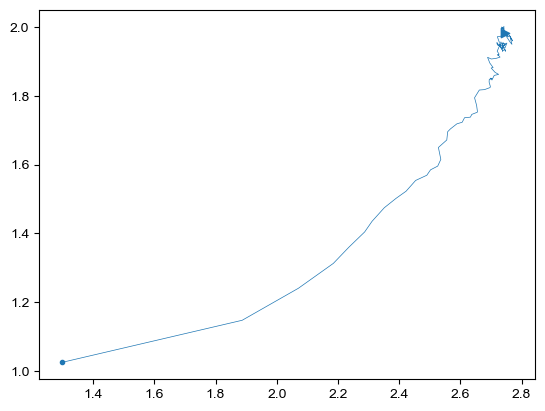

In [47]:
plt.plot(np.exp(logPara_histories_rev_3_delta_mean),np.exp(logPara_histories_rev_3_power_mean), linewidth = 0.5, color = palette[0])
plt.scatter(np.exp(logPara_histories_rev_3_delta_mean.head(1)),np.exp(logPara_histories_rev_3_power_mean.head(1)), marker = '.', color = palette[0])
plt.scatter(np.exp(logPara_histories_rev_3_delta_mean.tail(1)),np.exp(logPara_histories_rev_3_power_mean.tail(1)), marker = '>', color = palette[0])
plt.show()

In [48]:
survival_simulation_counts = pd.DataFrame()
for i in tqdm(range(revo_num+1),leave=False):
    survival_simulation_count_tmp = sim_num - np.sum(np.isnan(logPara_histories.loc[i]))/2
    survival_simulation_counts = pd.concat([survival_simulation_counts, pd.DataFrame([survival_simulation_count_tmp], index = [i], columns = ['Survivors'])], axis=0)

  0%|          | 0/101 [00:00<?, ?it/s]

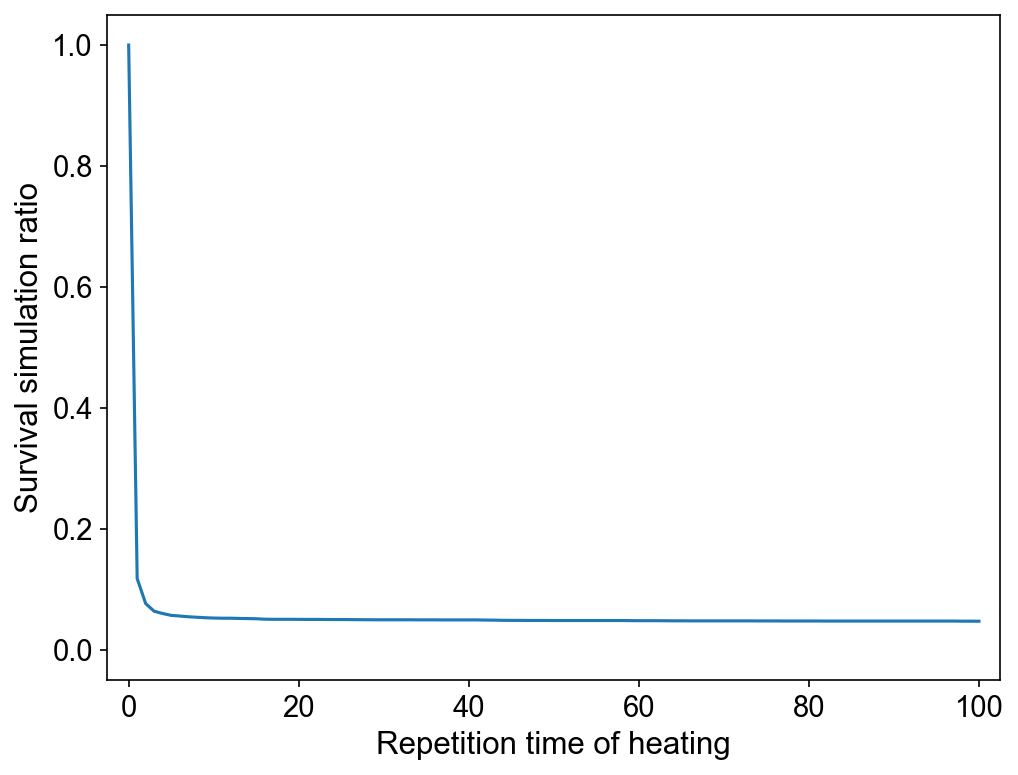

In [49]:

plt.figure(figsize=[6.4*1.2, 4.8*1.2], dpi=150)
plt.rcParams["font.family"] = "Arial"
plt.ylabel("Survival simulation ratio",size=15,fontname="Arial")
plt.xlabel("Repetition time of heating",size=15,fontname="Arial")
plt.plot(range(revo_num+1),survival_simulation_counts/sim_num, color = palette[0])
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,revo_num+2.5])
plt.savefig("Evo_Fig/Rev_3 simulation counts.pdf", bbox_inches="tight", dpi=150)
plt.show()

In [50]:
survival_simulation_counts

Survivors
0      10000.0
1       1178.0
2        765.0
3        638.0
4        601.0
..         ...
96       476.0
97       476.0
98       474.0
99       474.0
100      473.0

[101 rows x 1 columns]

In [51]:
Survival_simulation_ratio_rev_3 = survival_simulation_counts/sim_num

In [52]:
t_heating = 0
warnings.simplefilter('ignore', RuntimeWarning)
Sim_results =[]
ns = range(sim_num)
with ProcessPoolExecutor(processor_num) as e:
    ret = e.map(heat_rev, ns)
logPara_histories = [r for r in ret]
logPara_histories = pd.concat(logPara_histories, axis=1)

In [53]:
logPara_histories

logdelta 0  logpower 0  logdelta 1  logpower 1  logdelta 2  logpower 2  \
0      0.302447    0.431105     0.22697   -0.231822    0.417707    0.036302   
1      0.518800    0.492800     0.15350   -0.019900    0.481400    0.030700   
2      0.610900    0.187400     0.19330    0.173800    0.482600   -0.136700   
3      0.610900    0.187400     0.26760    0.163700    0.262100    0.019700   
4      0.610900    0.187400     0.36750    0.414300    0.214200    0.060300   
..          ...         ...         ...         ...         ...         ...   
96    -0.015600   -0.444400    -0.27090   -0.387900    0.107300   -0.193300   
97    -0.058800   -0.398400    -0.32390   -0.308900    0.047300   -0.225300   
98    -0.066300   -0.309500    -0.32390   -0.308900    0.028200   -0.202500   
99     0.011200   -0.289400    -0.19720   -0.453200    0.132400   -0.304200   
100   -0.020100   -0.270800    -0.19340   -0.402500    0.282700   -0.528500   

     logdelta 3  logpower 3  logdelta 4  logpower 4  ...  logdelta 9995  \
0      0.030729    0.015013    0.396423    0.235764  ...       0.263001   
1      0.107400    0.208900    0.428000    0.286000  ...       0.240100   
2      0.127600    0.145900    0.408100    0.268800  ...       0.171100   
3      0.208800    0.123900    0.477300    0.188500  ...       0.055900   
4      0.231500    0.205900    0.469100    0.195700  ...       0.068200   
..          ...         ...         ...         ...  ...            ...   
96     0.556000   -0.469100    0.205100    0.029800  ...       0.333800   
97     0.556000   -0.469100    0.395500    0.058400  ...       0.421700   
98     0.457900   -0.464000    0.377800    0.085200  ...       0.499200   
99     0.457900   -0.464000    0.353600    0.027200  ...       0.331300   
100    0.537700   -0.641400    0.163000    0.133200  ...       0.273200   

     logpower 9995  logdelta 9996  logpower 9996  logdelta 9997  \
0         0.220955       0.108068       0.283268       0.085549   
1         0.184500       0.075900       0.462200       0.163600   
2         0.099200       0.071200       0.373900       0.180000   
3         0.153200       0.051200       0.488100       0.248300   
4         0.159400       0.111300       0.347600       0.207800   
..             ...            ...            ...            ...   
96       -0.259800       0.141300       0.048400       0.586000   
97       -0.243600       0.142100       0.061100       0.525500   
98       -0.155900       0.286600       0.228300       0.520500   
99        0.093300       0.317800       0.261300       0.561000   
100       0.287500       0.482900       0.311400       0.566600   

     logpower 9997  logdelta 9998  logpower 9998  logdelta 9999  logpower 9999  
0        -0.182882       0.632158       0.487543       0.287387      -0.254249  
1         0.076000       0.684700       0.517500       0.240500      -0.172500  
2        -0.113300       0.740500       0.497000       0.240500      -0.172500  
3        -0.304600       0.577900       0.521600       0.276200       0.042400  
4        -0.256500       0.697900       0.376700       0.191700      -0.009500  
..             ...            ...            ...            ...            ...  
96       -0.021000       0.217800      -0.435700       0.264100       0.176700  
97        0.189500       0.205400      -0.387500       0.318000       0.035400  
98        0.152400       0.383300      -0.374300       0.318000       0.035400  
99        0.104200       0.383300      -0.374300       0.386200       0.008000  
100      -0.109200       0.383600      -0.376300       0.386200       0.008000  

[101 rows x 20000 columns]

palette = sns.color_palette(n_colors = sim_num)
for j in tqdm(range(sim_num),leave=False):
    plt.plot(logPara_histories['logdelta '+str(j)],logPara_histories['logpower '+str(j)], linewidth = 0.5, color = palette[j], alpha=0.1)
for j in tqdm(range(sim_num),leave=False):
    plt.scatter(logPara_histories['logdelta '+str(j)].head(1),logPara_histories['logpower '+str(j)].head(1), marker = '.', color = palette[j], alpha=0.1)
for j in tqdm(range(sim_num),leave=False):
    if np.isnan(logPara_histories['logdelta '+str(j)].tail(1).iloc[0]):
        plt.scatter(logPara_histories['logdelta '+str(j)].dropna(how='all', axis=0).tail(1),logPara_histories['logpower '+str(j)].dropna(how='all', axis=0).tail(1), marker = 'x', color = palette[j], alpha=0.1)
for j in tqdm(range(sim_num),leave=False):
    if logPara_histories['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(logPara_histories['logdelta '+str(j)].tail(1),logPara_histories['logpower '+str(j)].tail(1), marker = '>', color = palette[j], alpha=0.1)
plt.show()

palette = sns.color_palette(n_colors = sim_num)
for j in tqdm(range(sim_num),leave=False):
    plt.plot(np.exp(logPara_histories['logdelta '+str(j)]),np.exp(logPara_histories['logpower '+str(j)]), linewidth = 0.5, color = palette[j], alpha=0.1)
for j in tqdm(range(sim_num),leave=False):
    plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].head(1)),np.exp(logPara_histories['logpower '+str(j)].head(1)), marker = '.', color = palette[j], alpha=0.1)
for j in tqdm(range(sim_num),leave=False):
    if np.isnan(logPara_histories['logdelta '+str(j)].tail(1).iloc[0]):
        plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].dropna(how='all', axis=1).tail(1)),np.exp(logPara_histories['logpower '+str(j)].dropna(how='all', axis=1).tail(1)), marker = 'x', color = palette[j], alpha=0.1)
for j in tqdm(range(sim_num),leave=False):
    if logPara_histories['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].tail(1)),np.exp(logPara_histories['logpower '+str(j)].tail(1)), marker = '>', color = palette[j], alpha=0.1)
plt.show()

In [54]:
logPara_histories_non = logPara_histories
logPara_histories_non

logdelta 0  logpower 0  logdelta 1  logpower 1  logdelta 2  logpower 2  \
0      0.302447    0.431105     0.22697   -0.231822    0.417707    0.036302   
1      0.518800    0.492800     0.15350   -0.019900    0.481400    0.030700   
2      0.610900    0.187400     0.19330    0.173800    0.482600   -0.136700   
3      0.610900    0.187400     0.26760    0.163700    0.262100    0.019700   
4      0.610900    0.187400     0.36750    0.414300    0.214200    0.060300   
..          ...         ...         ...         ...         ...         ...   
96    -0.015600   -0.444400    -0.27090   -0.387900    0.107300   -0.193300   
97    -0.058800   -0.398400    -0.32390   -0.308900    0.047300   -0.225300   
98    -0.066300   -0.309500    -0.32390   -0.308900    0.028200   -0.202500   
99     0.011200   -0.289400    -0.19720   -0.453200    0.132400   -0.304200   
100   -0.020100   -0.270800    -0.19340   -0.402500    0.282700   -0.528500   

     logdelta 3  logpower 3  logdelta 4  logpower 4  ...  logdelta 9995  \
0      0.030729    0.015013    0.396423    0.235764  ...       0.263001   
1      0.107400    0.208900    0.428000    0.286000  ...       0.240100   
2      0.127600    0.145900    0.408100    0.268800  ...       0.171100   
3      0.208800    0.123900    0.477300    0.188500  ...       0.055900   
4      0.231500    0.205900    0.469100    0.195700  ...       0.068200   
..          ...         ...         ...         ...  ...            ...   
96     0.556000   -0.469100    0.205100    0.029800  ...       0.333800   
97     0.556000   -0.469100    0.395500    0.058400  ...       0.421700   
98     0.457900   -0.464000    0.377800    0.085200  ...       0.499200   
99     0.457900   -0.464000    0.353600    0.027200  ...       0.331300   
100    0.537700   -0.641400    0.163000    0.133200  ...       0.273200   

     logpower 9995  logdelta 9996  logpower 9996  logdelta 9997  \
0         0.220955       0.108068       0.283268       0.085549   
1         0.184500       0.075900       0.462200       0.163600   
2         0.099200       0.071200       0.373900       0.180000   
3         0.153200       0.051200       0.488100       0.248300   
4         0.159400       0.111300       0.347600       0.207800   
..             ...            ...            ...            ...   
96       -0.259800       0.141300       0.048400       0.586000   
97       -0.243600       0.142100       0.061100       0.525500   
98       -0.155900       0.286600       0.228300       0.520500   
99        0.093300       0.317800       0.261300       0.561000   
100       0.287500       0.482900       0.311400       0.566600   

     logpower 9997  logdelta 9998  logpower 9998  logdelta 9999  logpower 9999  
0        -0.182882       0.632158       0.487543       0.287387      -0.254249  
1         0.076000       0.684700       0.517500       0.240500      -0.172500  
2        -0.113300       0.740500       0.497000       0.240500      -0.172500  
3        -0.304600       0.577900       0.521600       0.276200       0.042400  
4        -0.256500       0.697900       0.376700       0.191700      -0.009500  
..             ...            ...            ...            ...            ...  
96       -0.021000       0.217800      -0.435700       0.264100       0.176700  
97        0.189500       0.205400      -0.387500       0.318000       0.035400  
98        0.152400       0.383300      -0.374300       0.318000       0.035400  
99        0.104200       0.383300      -0.374300       0.386200       0.008000  
100      -0.109200       0.383600      -0.376300       0.386200       0.008000  

[101 rows x 20000 columns]

  0%|          | 0/10000 [00:00<?, ?it/s]

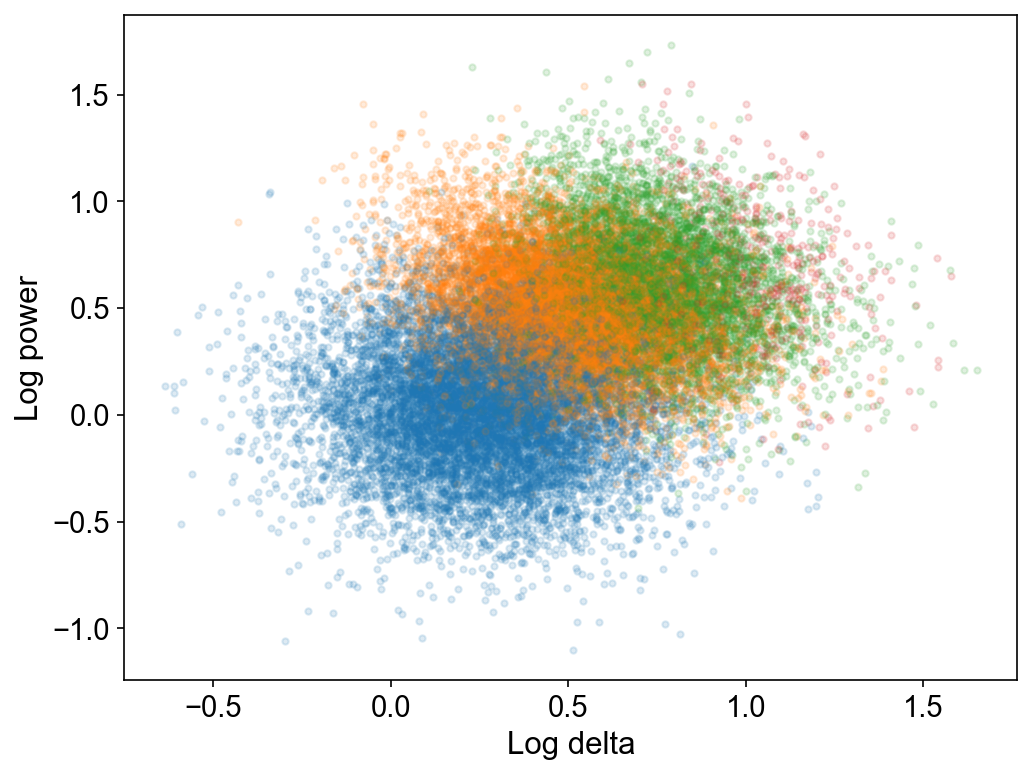

In [55]:
plt.figure(figsize=[6.4*1.2, 4.8*1.2], dpi=150)
plt.rcParams["font.family"] = "Arial"
plt.xlabel("Log delta",size=15,fontname="Arial")
plt.ylabel("Log power",size=15,fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)


for j in tqdm(range(sim_num),leave=False):
    if logPara_histories_non['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(logPara_histories_non['logdelta '+str(j)].tail(1),logPara_histories_non['logpower '+str(j)].tail(1), marker = '.', color = palette[0], alpha=0.15)
    if logPara_histories_non['logdelta '+str(j)].tail(1).iloc[0]==np.nan:
        plt.scatter(logPara_histories_non['logdelta '+str(j)].dropna(how='all', axis=0).tail(1),logPara_histories_non['logpower '+str(j)].dropna(how='all', axis=0).tail(1), marker = 'x', color = palette[0], alpha=0.15)
    
    if logPara_histories_rev['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(logPara_histories_rev['logdelta '+str(j)].tail(1),logPara_histories_rev['logpower '+str(j)].tail(1), marker = '.', color = palette[1], alpha=0.15)
    if logPara_histories_rev['logdelta '+str(j)].tail(1).iloc[0]==np.nan:
        plt.scatter(logPara_histories_rev['logdelta '+str(j)].dropna(how='all', axis=0).tail(1),logPara_histories_rev['logpower '+str(j)].dropna(how='all', axis=0).tail(1), marker = 'x', color = palette[1], alpha=0.15)

    if logPara_histories_rev_2['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(logPara_histories_rev_2['logdelta '+str(j)].tail(1),logPara_histories_rev_2['logpower '+str(j)].tail(1), marker = '.', color = palette[2], alpha=0.15)
    if logPara_histories_rev_2['logdelta '+str(j)].tail(1).iloc[0]==np.nan:
        plt.scatter(logPara_histories_rev_2['logdelta '+str(j)].dropna(how='all', axis=0).tail(1),logPara_histories_rev_2['logpower '+str(j)].dropna(how='all', axis=0).tail(1), marker = 'x', color = palette[2], alpha=0.15)

    if logPara_histories_rev_3['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(logPara_histories_rev_3['logdelta '+str(j)].tail(1),logPara_histories_rev_3['logpower '+str(j)].tail(1), marker = '.', color = palette[3], alpha=0.15)
    if logPara_histories_rev_3['logdelta '+str(j)].tail(1).iloc[0]==np.nan:
        plt.scatter(logPara_histories_rev_3['logdelta '+str(j)].dropna(how='all', axis=0).tail(1),logPara_histories_rev_3['logpower '+str(j)].dropna(how='all', axis=0).tail(1), marker = 'x', color = palette[3], alpha=0.15)

plt.savefig("Evo_Fig/Survival log parameters.pdf", bbox_inches="tight", dpi=150)

plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

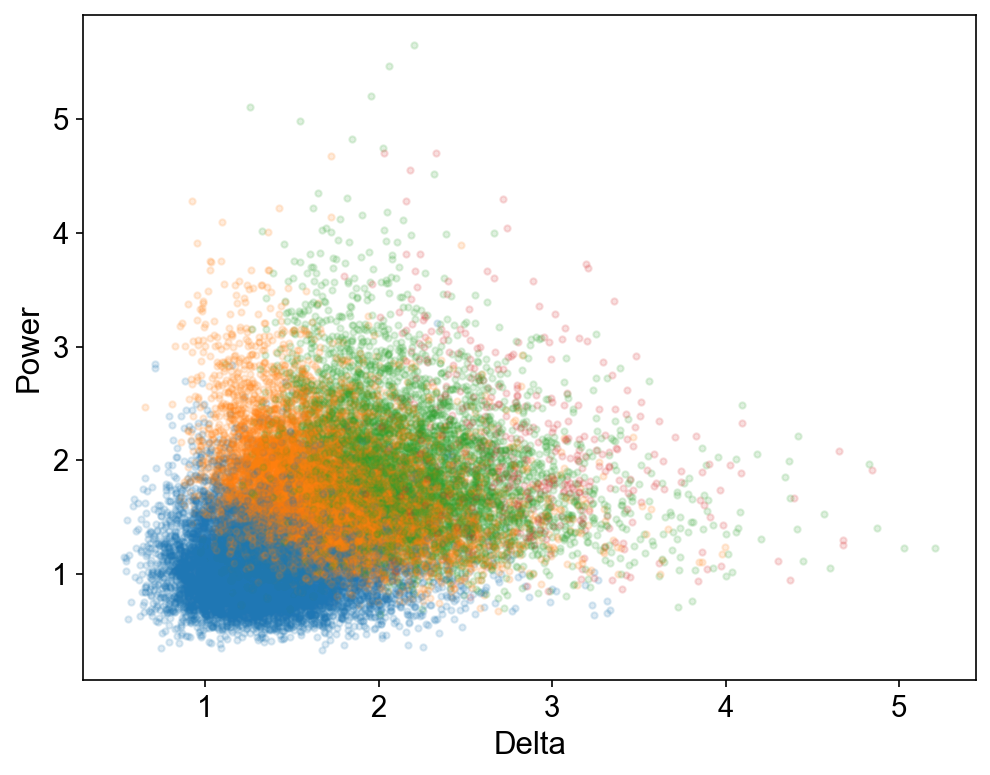

In [56]:
plt.figure(figsize=[6.4*1.2, 4.8*1.2], dpi=150)
plt.rcParams["font.family"] = "Arial"
plt.xlabel("Delta",size=15,fontname="Arial")
plt.ylabel("Power",size=15,fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)
for j in tqdm(range(sim_num),leave=False):
    if logPara_histories_non['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(np.exp(logPara_histories_non['logdelta '+str(j)].tail(1)),np.exp(logPara_histories_non['logpower '+str(j)].tail(1)), marker = '.', color = palette[0], alpha=0.15)
    if logPara_histories_non['logdelta '+str(j)].tail(1).iloc[0]==np.nan:
        plt.scatter(np.exp(logPara_histories_non['logdelta '+str(j)].dropna(how='all', axis=0).tail(1)),np.exp(logPara_histories_non['logpower '+str(j)].dropna(how='all', axis=0).tail(1)), marker = 'x', color = palette[0], alpha=0.15)
    
    if logPara_histories_rev['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(np.exp(logPara_histories_rev['logdelta '+str(j)].tail(1)),np.exp(logPara_histories_rev['logpower '+str(j)].tail(1)), marker = '.', color = palette[1], alpha=0.15)
    if logPara_histories_rev['logdelta '+str(j)].tail(1).iloc[0]==np.nan:
        plt.scatter(np.exp(logPara_histories_rev['logdelta '+str(j)].dropna(how='all', axis=0).tail(1)),np.exp(logPara_histories_rev['logpower '+str(j)].dropna(how='all', axis=0).tail(1)), marker = 'x', color = palette[1], alpha=0.15)

    if logPara_histories_rev_2['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(np.exp(logPara_histories_rev_2['logdelta '+str(j)].tail(1)),np.exp(logPara_histories_rev_2['logpower '+str(j)].tail(1)), marker = '.', color = palette[2], alpha=0.15)
    if logPara_histories_rev_2['logdelta '+str(j)].tail(1).iloc[0]==np.nan:
        plt.scatter(np.exp(logPara_histories_rev_2['logdelta '+str(j)].dropna(how='all', axis=0).tail(1)),np.exp(logPara_histories_rev_2['logpower '+str(j)].dropna(how='all', axis=0).tail(1)), marker = 'x', color = palette[2], alpha=0.15)
        
    if logPara_histories_rev_3['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(np.exp(logPara_histories_rev_3['logdelta '+str(j)].tail(1)),np.exp(logPara_histories_rev_3['logpower '+str(j)].tail(1)), marker = '.', color = palette[3], alpha=0.15)
    if logPara_histories_rev_3['logdelta '+str(j)].tail(1).iloc[0]==np.nan:
        plt.scatter(np.exp(logPara_histories_rev_3['logdelta '+str(j)].dropna(how='all', axis=0).tail(1)),np.exp(logPara_histories_rev_3['logpower '+str(j)].dropna(how='all', axis=0).tail(1)), marker = 'x', color = palette[3], alpha=0.15)
plt.savefig("Evo_Fig/Survival parameters.pdf", bbox_inches="tight", dpi=150)
plt.show()

In [57]:
logPara_histories_rev_0 = logPara_histories
logPara_histories_rev_0_delta = logPara_histories_rev_0[logPara_histories_rev_0.columns[logPara_histories_rev_0.columns.str.startswith("logdelta")]]
logPara_histories_rev_0_power = logPara_histories_rev_0[logPara_histories_rev_0.columns[logPara_histories_rev_0.columns.str.startswith("logpower")]]
logPara_histories_rev_0_delta_mean = logPara_histories_rev_0_delta.mean(axis=1)
logPara_histories_rev_0_power_mean = logPara_histories_rev_0_power.mean(axis=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

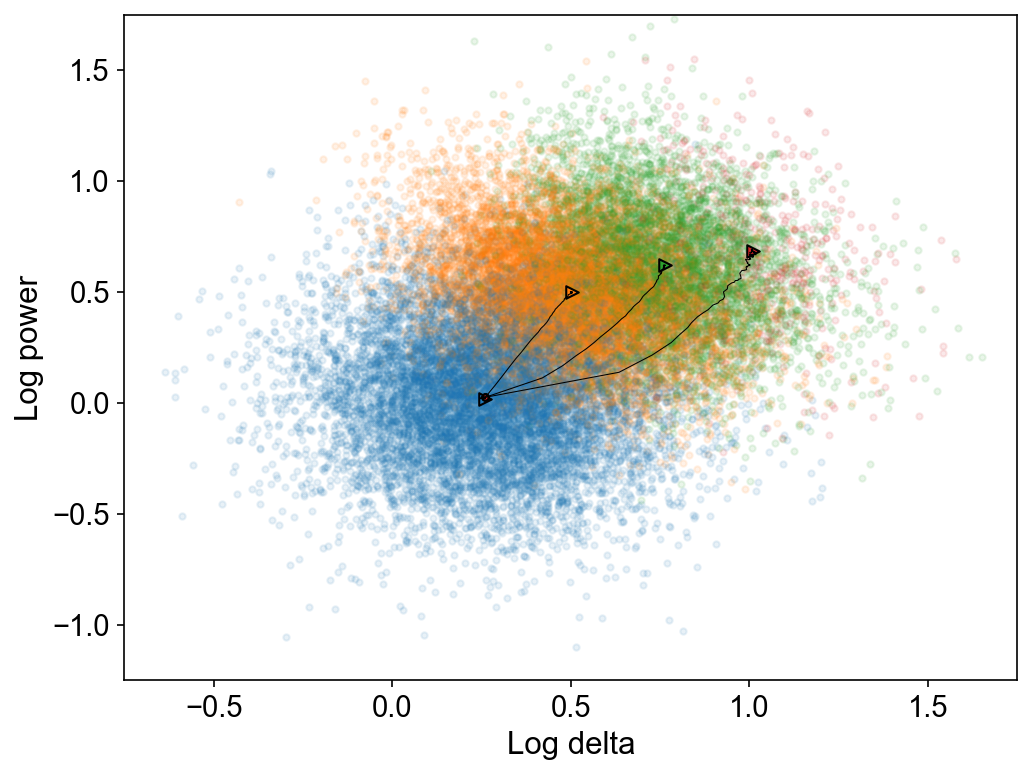

In [58]:
plt.figure(figsize=[6.4*1.2, 4.8*1.2], dpi=150)
plt.rcParams["font.family"] = "Arial"
plt.xlabel("Log delta",size=15,fontname="Arial")
plt.ylabel("Log power",size=15,fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)

for j in tqdm(range(sim_num),leave=False):
    if logPara_histories_non['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(logPara_histories_non['logdelta '+str(j)].tail(1),logPara_histories_non['logpower '+str(j)].tail(1), marker = '.', color = palette[0], alpha=0.1)
    if logPara_histories_non['logdelta '+str(j)].tail(1).iloc[0]==np.nan:
        plt.scatter(logPara_histories_non['logdelta '+str(j)].dropna(how='all', axis=0).tail(1),logPara_histories_non['logpower '+str(j)].dropna(how='all', axis=0).tail(1), marker = 'x', color = palette[0], alpha=0.1)
    
    if logPara_histories_rev['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(logPara_histories_rev['logdelta '+str(j)].tail(1),logPara_histories_rev['logpower '+str(j)].tail(1), marker = '.', color = palette[1], alpha=0.1)
    if logPara_histories_rev['logdelta '+str(j)].tail(1).iloc[0]==np.nan:
        plt.scatter(logPara_histories_rev['logdelta '+str(j)].dropna(how='all', axis=0).tail(1),logPara_histories_rev['logpower '+str(j)].dropna(how='all', axis=0).tail(1), marker = 'x', color = palette[1], alpha=0.1)

    if logPara_histories_rev_2['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(logPara_histories_rev_2['logdelta '+str(j)].tail(1),logPara_histories_rev_2['logpower '+str(j)].tail(1), marker = '.', color = palette[2], alpha=0.1)
    if logPara_histories_rev_2['logdelta '+str(j)].tail(1).iloc[0]==np.nan:
        plt.scatter(logPara_histories_rev_2['logdelta '+str(j)].dropna(how='all', axis=0).tail(1),logPara_histories_rev_2['logpower '+str(j)].dropna(how='all', axis=0).tail(1), marker = 'x', color = palette[2], alpha=0.1)

    if logPara_histories_rev_3['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(logPara_histories_rev_3['logdelta '+str(j)].tail(1),logPara_histories_rev_3['logpower '+str(j)].tail(1), marker = '.', color = palette[3], alpha=0.1)
    if logPara_histories_rev_3['logdelta '+str(j)].tail(1).iloc[0]==np.nan:
        plt.scatter(logPara_histories_rev_3['logdelta '+str(j)].dropna(how='all', axis=0).tail(1),logPara_histories_rev_3['logpower '+str(j)].dropna(how='all', axis=0).tail(1), marker = 'x', color = palette[3], alpha=0.1)

plt.plot(logPara_histories_rev_0_delta_mean,logPara_histories_rev_0_power_mean, linewidth = 0.5, color = "black")
plt.scatter(logPara_histories_rev_0_delta_mean.head(1),logPara_histories_rev_0_power_mean.head(1), marker = '.', edgecolors = "black", facecolors = palette[0])
plt.scatter(logPara_histories_rev_0_delta_mean.tail(1),logPara_histories_rev_0_power_mean.tail(1), marker = '>', edgecolors = "black", facecolors = palette[0])

plt.plot(logPara_histories_rev_delta_mean,logPara_histories_rev_power_mean, linewidth = 0.5, color = "black")
plt.scatter(logPara_histories_rev_delta_mean.head(1),logPara_histories_rev_power_mean.head(1), marker = '.', edgecolors = "black", facecolors = palette[1])
plt.scatter(logPara_histories_rev_delta_mean.tail(1),logPara_histories_rev_power_mean.tail(1), marker = '>', edgecolors = "black", facecolors = palette[1])

plt.plot(logPara_histories_rev_2_delta_mean,logPara_histories_rev_2_power_mean, linewidth = 0.5, color = "black")
plt.scatter(logPara_histories_rev_2_delta_mean.head(1),logPara_histories_rev_2_power_mean.head(1), marker = '.', edgecolors = "black", facecolors = palette[2])
plt.scatter(logPara_histories_rev_2_delta_mean.tail(1),logPara_histories_rev_2_power_mean.tail(1), marker = '>', edgecolors = "black", facecolors = palette[2])

plt.plot(logPara_histories_rev_3_delta_mean,logPara_histories_rev_3_power_mean, linewidth = 0.5, color = "black")
plt.scatter(logPara_histories_rev_3_delta_mean.head(1),logPara_histories_rev_3_power_mean.head(1), marker = '.', edgecolors = "black", facecolors = palette[3])
plt.scatter(logPara_histories_rev_3_delta_mean.tail(1),logPara_histories_rev_3_power_mean.tail(1), marker = '>', edgecolors = "black", facecolors = palette[3])
plt.xlim([-0.75,1.75])
plt.ylim([-1.25,1.75])
plt.savefig("Evo_Fig/Survival mean log parameters.pdf", bbox_inches="tight", dpi=150)
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

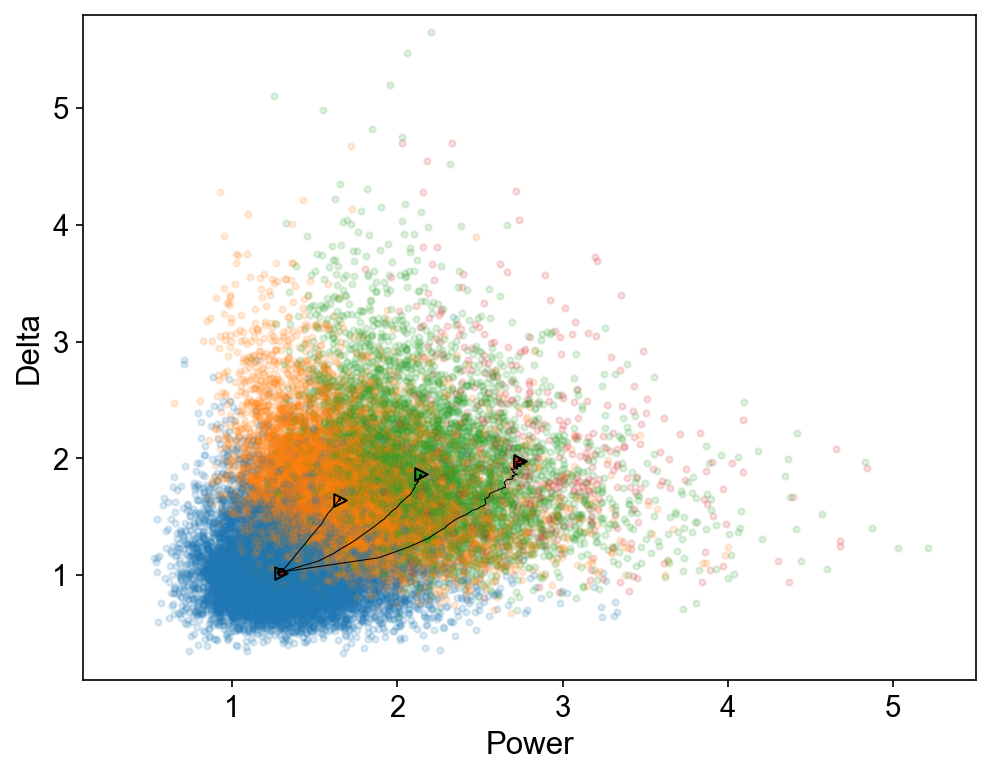

In [59]:
plt.figure(figsize=[6.4*1.2, 4.8*1.2], dpi=150)
plt.rcParams["font.family"] = "Arial"
plt.ylabel("Delta",size=15,fontname="Arial")
plt.xlabel("Power",size=15,fontname="Arial")
plt.xticks(size=14)
plt.yticks(size=14)

for j in tqdm(range(sim_num),leave=False):
    if logPara_histories_non['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(np.exp(logPara_histories_non['logdelta '+str(j)].tail(1)),np.exp(logPara_histories_non['logpower '+str(j)].tail(1)), marker = '.', color = palette[0], alpha=0.15)
    if logPara_histories_non['logdelta '+str(j)].tail(1).iloc[0]==np.nan:
        plt.scatter(np.exp(logPara_histories_non['logdelta '+str(j)].dropna(how='all', axis=0).tail(1)),np.exp(logPara_histories_non['logpower '+str(j)].dropna(how='all', axis=0).tail(1)), marker = 'x', color = palette[0], alpha=0.15)
    
    if logPara_histories_rev['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(np.exp(logPara_histories_rev['logdelta '+str(j)].tail(1)),np.exp(logPara_histories_rev['logpower '+str(j)].tail(1)), marker = '.', color = palette[1], alpha=0.15)
    if logPara_histories_rev['logdelta '+str(j)].tail(1).iloc[0]==np.nan:
        plt.scatter(np.exp(logPara_histories_rev['logdelta '+str(j)].dropna(how='all', axis=0).tail(1)),np.exp(logPara_histories_rev['logpower '+str(j)].dropna(how='all', axis=0).tail(1)), marker = 'x', color = palette[1], alpha=0.15)

    if logPara_histories_rev_2['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(np.exp(logPara_histories_rev_2['logdelta '+str(j)].tail(1)),np.exp(logPara_histories_rev_2['logpower '+str(j)].tail(1)), marker = '.', color = palette[2], alpha=0.15)
    if logPara_histories_rev_2['logdelta '+str(j)].tail(1).iloc[0]==np.nan:
        plt.scatter(np.exp(logPara_histories_rev_2['logdelta '+str(j)].dropna(how='all', axis=0).tail(1)),np.exp(logPara_histories_rev_2['logpower '+str(j)].dropna(how='all', axis=0).tail(1)), marker = 'x', color = palette[2], alpha=0.15)
        
    if logPara_histories_rev_3['logdelta '+str(j)].tail(1).iloc[0]!=np.nan:
        plt.scatter(np.exp(logPara_histories_rev_3['logdelta '+str(j)].tail(1)),np.exp(logPara_histories_rev_3['logpower '+str(j)].tail(1)), marker = '.', color = palette[3], alpha=0.15)
    if logPara_histories_rev_3['logdelta '+str(j)].tail(1).iloc[0]==np.nan:
        plt.scatter(np.exp(logPara_histories_rev_3['logdelta '+str(j)].dropna(how='all', axis=0).tail(1)),np.exp(logPara_histories_rev_3['logpower '+str(j)].dropna(how='all', axis=0).tail(1)), marker = 'x', color = palette[3], alpha=0.15)

plt.plot(np.exp(logPara_histories_rev_0_delta_mean),np.exp(logPara_histories_rev_0_power_mean), linewidth = 0.5, color = "black")
plt.scatter(np.exp(logPara_histories_rev_0_delta_mean.head(1)),np.exp(logPara_histories_rev_0_power_mean.head(1)), marker = '.', edgecolors = "black", facecolors = palette[0])
plt.scatter(np.exp(logPara_histories_rev_0_delta_mean.tail(1)),np.exp(logPara_histories_rev_0_power_mean.tail(1)), marker = '>', edgecolors = "black", facecolors = palette[0])

plt.plot(np.exp(logPara_histories_rev_delta_mean),np.exp(logPara_histories_rev_power_mean), linewidth = 0.5, color = "black")
plt.scatter(np.exp(logPara_histories_rev_delta_mean.head(1)),np.exp(logPara_histories_rev_power_mean.head(1)), marker = '.', edgecolors = "black", facecolors = palette[1])
plt.scatter(np.exp(logPara_histories_rev_delta_mean.tail(1)),np.exp(logPara_histories_rev_power_mean.tail(1)), marker = '>', edgecolors = "black", facecolors = palette[1])

plt.plot(np.exp(logPara_histories_rev_2_delta_mean),np.exp(logPara_histories_rev_2_power_mean), linewidth = 0.5, color = "black")
plt.scatter(np.exp(logPara_histories_rev_2_delta_mean.head(1)),np.exp(logPara_histories_rev_2_power_mean.head(1)), marker = '.', edgecolors = "black", facecolors = palette[2])
plt.scatter(np.exp(logPara_histories_rev_2_delta_mean.tail(1)),np.exp(logPara_histories_rev_2_power_mean.tail(1)), marker = '>', edgecolors = "black", facecolors = palette[2])

plt.plot(np.exp(logPara_histories_rev_3_delta_mean),np.exp(logPara_histories_rev_3_power_mean), linewidth = 0.5, color = "black")
plt.scatter(np.exp(logPara_histories_rev_3_delta_mean.head(1)),np.exp(logPara_histories_rev_3_power_mean.head(1)), marker = '.', edgecolors = "black", facecolors = palette[3])
plt.scatter(np.exp(logPara_histories_rev_3_delta_mean.tail(1)),np.exp(logPara_histories_rev_3_power_mean.tail(1)), marker = '>', edgecolors = "black", facecolors = palette[3])

plt.xlim([0.1,5.5])
plt.ylim([0.1,5.8])
plt.savefig("Evo_Fig/Survival mean parameters.pdf", bbox_inches="tight", dpi=150)
plt.show()

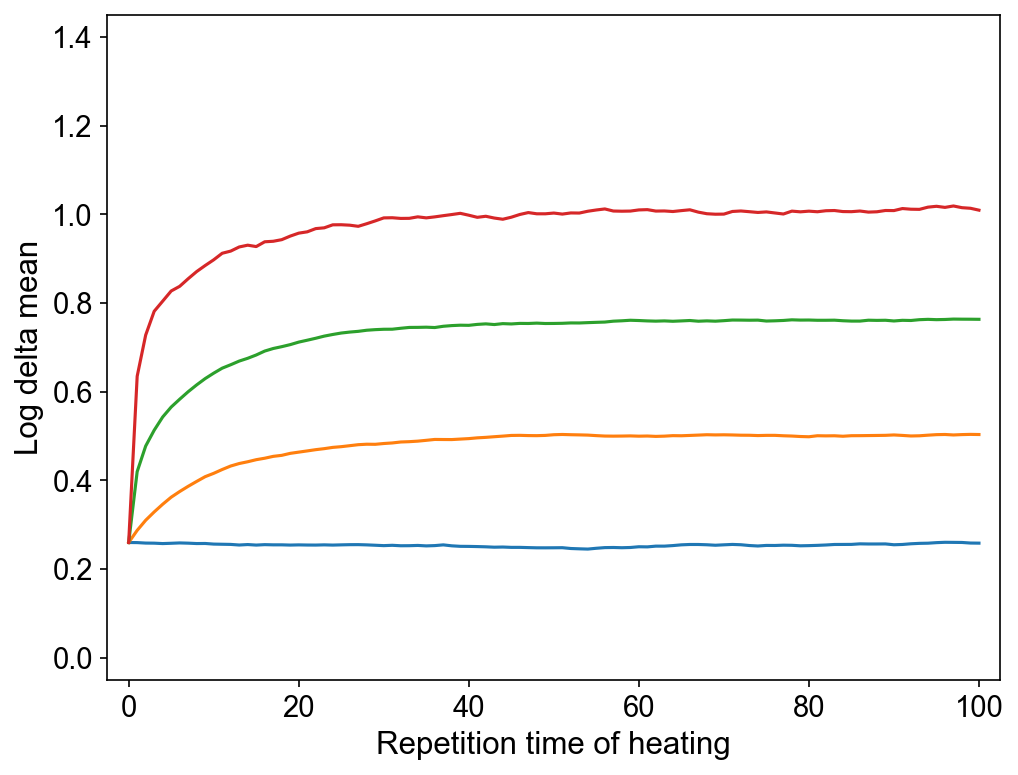

In [60]:
plt.figure(figsize=[6.4*1.2, 4.8*1.2], dpi=150)
plt.rcParams["font.family"] = "Arial"
plt.ylabel("Log delta mean",size=15,fontname="Arial")
plt.xlabel("Repetition time of heating",size=15,fontname="Arial")

plt.plot(range(revo_num+1),logPara_histories_rev_0_delta_mean, color = palette[0])
plt.plot(range(revo_num+1),logPara_histories_rev_delta_mean, color = palette[1])
plt.plot(range(revo_num+1),logPara_histories_rev_2_delta_mean, color = palette[2])
plt.plot(range(revo_num+1),logPara_histories_rev_3_delta_mean, color = palette[3])
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([-0.05,1.45])
plt.xlim([-2.5,revo_num+2.5])
plt.savefig("Evo_Fig/Rev_delta_mean.pdf", bbox_inches="tight", dpi=150)
plt.show()

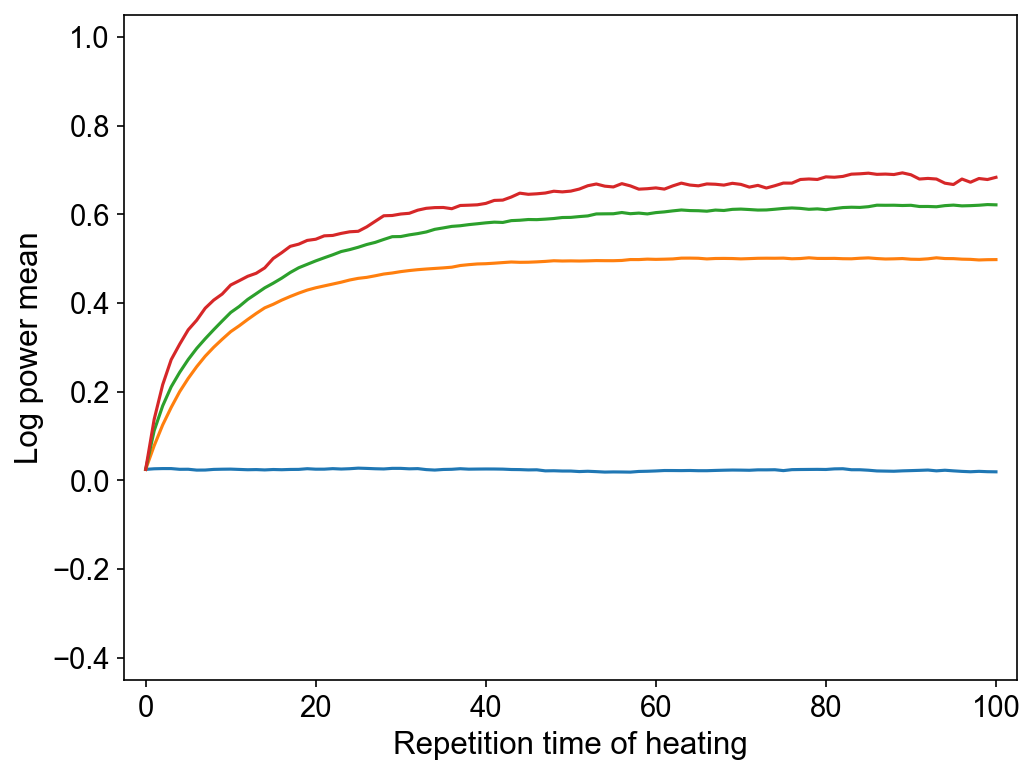

In [61]:
plt.figure(figsize=[6.4*1.2, 4.8*1.2], dpi=150)
plt.rcParams["font.family"] = "Arial"
plt.ylabel("Log power mean",size=15,fontname="Arial")
plt.xlabel("Repetition time of heating",size=15,fontname="Arial")

plt.plot(range(revo_num+1),logPara_histories_rev_0_power_mean, color = palette[0])
plt.plot(range(revo_num+1),logPara_histories_rev_power_mean, color = palette[1])
plt.plot(range(revo_num+1),logPara_histories_rev_2_power_mean, color = palette[2])
plt.plot(range(revo_num+1),logPara_histories_rev_3_power_mean, color = palette[3])
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([-0.45,1.05])
plt.xlim([-2.5,revo_num+2.5])
plt.savefig("Evo_Fig/Rev_power_mean.pdf", bbox_inches="tight", dpi=150)
plt.show()

In [62]:
survival_simulation_counts = pd.DataFrame()
for i in tqdm(range(revo_num+1),leave=False):
    survival_simulation_count_tmp = sim_num - np.sum(np.isnan(logPara_histories.loc[i]))/2
    survival_simulation_counts = pd.concat([survival_simulation_counts, pd.DataFrame([survival_simulation_count_tmp], index = [i], columns = ['Survivors'])], axis=0)

  0%|          | 0/101 [00:00<?, ?it/s]

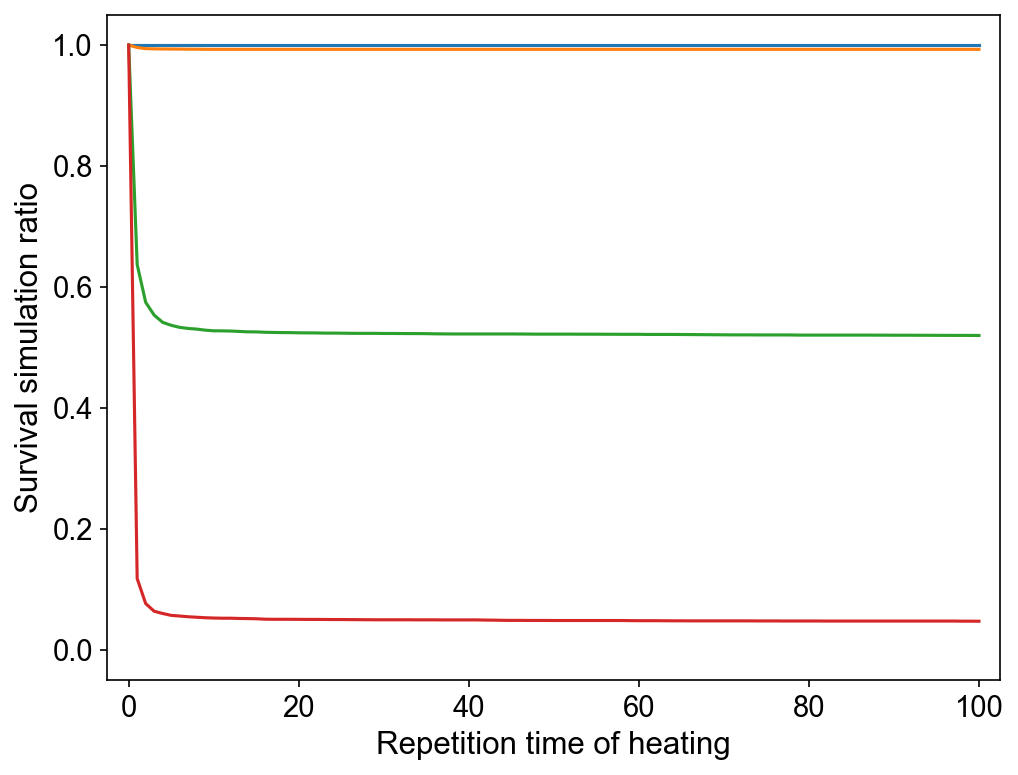

In [63]:
plt.figure(figsize=[6.4*1.2, 4.8*1.2], dpi=150)
plt.rcParams["font.family"] = "Arial"
plt.ylabel("Survival simulation ratio",size=15,fontname="Arial")
plt.xlabel("Repetition time of heating",size=15,fontname="Arial")
plt.plot(range(revo_num+1),survival_simulation_counts/sim_num, color = palette[0])
plt.plot(range(revo_num+1),Survival_simulation_ratio_rev, color = palette[1])
plt.plot(range(revo_num+1),Survival_simulation_ratio_rev_2, color = palette[2])
plt.plot(range(revo_num+1),Survival_simulation_ratio_rev_3, color = palette[3])
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([-0.05,1.05])
plt.xlim([-2.5,revo_num+2.5])
plt.savefig("Evo_Fig/Rev simulation counts.pdf", bbox_inches="tight", dpi=150)
plt.show()

In [64]:
Simed_params = {
    'delta': [],
    'power': [],
    'sim_name': []
}
Simed_paras = pd.DataFrame(Simed_params)

In [65]:
survival_simulation_counts = pd.DataFrame()
for i in tqdm(range(revo_num+1),leave=False):
    survival_simulation_count_tmp = sim_num - np.sum(np.isnan(logPara_histories.loc[i]))/2
    survival_simulation_counts = pd.concat([survival_simulation_counts, pd.DataFrame([survival_simulation_count_tmp], index = [i], columns = ['Survivors'])], axis=0)

  0%|          | 0/101 [00:00<?, ?it/s]

time_min = 0
time_max = 12
devide = (time_max-time_min)*10
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")

def Fit_Model(t, delta, power) :
    return -6*(t/6/delta)**power


logPara_histories_rev_survivors = logPara_histories_rev.dropna(axis=1)

Num_mcmc = sim_num
logS_credible_mcmc = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)
logS_rev_credible_mcmc = np.zeros((len(time_interval),len(logPara_histories_rev.dropna(axis=1).columns)), dtype=float)
logS_rev_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        delta_sim = np.exp(logPara_histories['logdelta '+str(k)].dropna(how='all', axis=0).tail(1))
        power_sim = np.exp(logPara_histories['logdelta '+str(k)].dropna(how='all', axis=0).tail(1))
        logS_credible_mcmc[j,k] = Fit_Model(time_interval[j], delta_sim, power_sim)

    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc[j,:],[0.005,  0.5, 0.995])

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    for k in range(int(len(logPara_histories_rev.dropna(axis=1).columns)/2)):
        delta_sim = np.exp(logPara_histories_rev[logPara_histories_rev.dropna(axis=1).columns[k*2]].dropna(how='all', axis=0).tail(1))
        power_sim = np.exp(logPara_histories_rev[logPara_histories_rev.dropna(axis=1).columns[k*2+1]].dropna(how='all', axis=0).tail(1))
        logS_rev_credible_mcmc[j,k] = Fit_Model(time_interval[j], delta_sim, power_sim)

    logS_rev_credible_mcmc_quantile[j,:] = np.quantile(logS_rev_credible_mcmc[j,:],[0.005,  0.5, 0.995])

In [66]:
time_min = 0
time_max = 12
devide = (time_max-time_min)*10
time_interval = np.arange(time_min, time_max*(devide+1)/devide,
                          (time_max-time_min)/devide, dtype="float")

def Fit_Model(t, delta, power) :
    return -6*(t/6/delta)**power


logPara_histories_rev_survivors = logPara_histories_rev.dropna(axis=1)
logPara_histories_rev_2_survivors = logPara_histories_rev_2.dropna(axis=1)
logPara_histories_rev_3_survivors = logPara_histories_rev_3.dropna(axis=1)

Num_mcmc = sim_num
logS_credible_mcmc_list = np.zeros((len(time_interval),Num_mcmc), dtype=float)
logS_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)
logS_rev_credible_mcmc_list = np.zeros((len(time_interval),int(len(logPara_histories_rev.dropna(axis=1).columns)/2)), dtype=float)
logS_rev_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)
logS_rev_2_credible_mcmc_list = np.zeros((len(time_interval),int(len(logPara_histories_rev_2.dropna(axis=1).columns)/2)), dtype=float)
logS_rev_2_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)
logS_rev_3_credible_mcmc_list = np.zeros((len(time_interval),int(len(logPara_histories_rev_3.dropna(axis=1).columns)/2)), dtype=float)
logS_rev_3_credible_mcmc_quantile = np.zeros((len(time_interval), 3), dtype=float)


def Reductions(k):
    logS_credible_tmp = np.zeros(len(time_interval), dtype=float)
    for j in range(len(time_interval)):
        delta_sim = np.exp(logPara_histories['logdelta '+str(k)].dropna(how='all', axis=0).tail(1))
        power_sim = np.exp(logPara_histories['logdelta '+str(k)].dropna(how='all', axis=0).tail(1))
        logS_credible_tmp[j] = Fit_Model(time_interval[j], delta_sim, power_sim)
    return logS_credible_tmp

ns = range(Num_mcmc)
with ProcessPoolExecutor(processor_num) as e:
    ret = e.map(Reductions, ns)
logS_credible_mcmc = [r for r in ret]

for i in range(len(logS_credible_mcmc)):
    logS_credible_mcmc_list[:,i] = logS_credible_mcmc[i]

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    logS_credible_mcmc_quantile[j,:] = np.quantile(logS_credible_mcmc_list[j,:],[0.005,  0.5, 0.995])



def Reductions_rev(k):
    logS_credible_tmp = np.zeros(len(time_interval), dtype=float)
    for j in range(len(time_interval)):
        delta_sim = np.exp(logPara_histories_rev[logPara_histories_rev.dropna(axis=1).columns[k*2]].dropna(how='all', axis=0).tail(1))
        power_sim = np.exp(logPara_histories_rev[logPara_histories_rev.dropna(axis=1).columns[k*2+1]].dropna(how='all', axis=0).tail(1))
        logS_credible_tmp[j] = Fit_Model(time_interval[j], delta_sim, power_sim)
    return logS_credible_tmp

ns = range(int(len(logPara_histories_rev.dropna(axis=1).columns)/2))
with ProcessPoolExecutor(processor_num) as e:
    ret = e.map(Reductions_rev, ns)
logS_rev_credible_mcmc = [r for r in ret]

for i in range(len(logS_rev_credible_mcmc)):
    logS_rev_credible_mcmc_list[:,i] = logS_rev_credible_mcmc[i]

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    logS_rev_credible_mcmc_quantile[j,:] = np.quantile(logS_rev_credible_mcmc_list[j,:],[0.005,  0.5, 0.995])

    
def Reductions_rev_2(k):
    logS_credible_tmp = np.zeros(len(time_interval), dtype=float)
    for j in range(len(time_interval)):
        delta_sim = np.exp(logPara_histories_rev_2[logPara_histories_rev_2.dropna(axis=1).columns[k*2]].dropna(how='all', axis=0).tail(1))
        power_sim = np.exp(logPara_histories_rev_2[logPara_histories_rev_2.dropna(axis=1).columns[k*2+1]].dropna(how='all', axis=0).tail(1))
        logS_credible_tmp[j] = Fit_Model(time_interval[j], delta_sim, power_sim)
    return logS_credible_tmp

ns = range(int(len(logPara_histories_rev_2.dropna(axis=1).columns)/2))
with ProcessPoolExecutor(processor_num) as e:
    ret = e.map(Reductions_rev_2, ns)
logS_rev_2_credible_mcmc = [r for r in ret]

for i in range(len(logS_rev_2_credible_mcmc)):
    logS_rev_2_credible_mcmc_list[:,i] = logS_rev_2_credible_mcmc[i]

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    logS_rev_2_credible_mcmc_quantile[j,:] = np.quantile(logS_rev_2_credible_mcmc_list[j,:],[0.005,  0.5, 0.995])
    
    
def Reductions_rev_3(k):
    logS_credible_tmp = np.zeros(len(time_interval), dtype=float)
    for j in range(len(time_interval)):
        delta_sim = np.exp(logPara_histories_rev_3[logPara_histories_rev_3.dropna(axis=1).columns[k*2]].dropna(how='all', axis=0).tail(1))
        power_sim = np.exp(logPara_histories_rev_3[logPara_histories_rev_3.dropna(axis=1).columns[k*2+1]].dropna(how='all', axis=0).tail(1))
        logS_credible_tmp[j] = Fit_Model(time_interval[j], delta_sim, power_sim)
    return logS_credible_tmp

ns = range(int(len(logPara_histories_rev_3.dropna(axis=1).columns)/2))
with ProcessPoolExecutor(processor_num) as e:
    ret = e.map(Reductions_rev_3, ns)
logS_rev_3_credible_mcmc = [r for r in ret]

for i in range(len(logS_rev_3_credible_mcmc)):
    logS_rev_3_credible_mcmc_list[:,i] = logS_rev_3_credible_mcmc[i]

for j in tqdm(range(len(time_interval)),desc='Progress', leave=False):
    logS_rev_3_credible_mcmc_quantile[j,:] = np.quantile(logS_rev_3_credible_mcmc_list[j,:],[0.005,  0.5, 0.995])
    

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Progress:   0%|          | 0/121 [00:00<?, ?it/s]

In [67]:
len(logS_rev_credible_mcmc)

9929

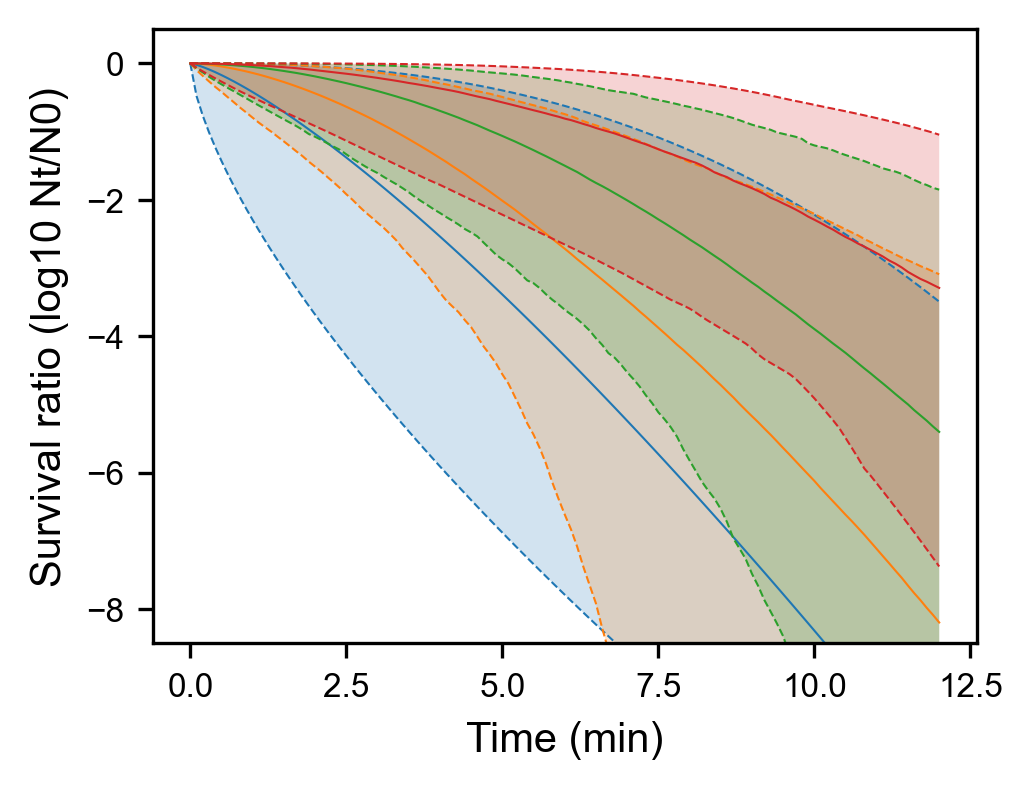

In [68]:
Palette = sns.color_palette(n_colors = 4)
plt.figure(figsize=(9*0.393701,9*0.393701*3/4), dpi=300)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[0], alpha=0.2)
plt.fill_between(time_interval, logS_rev_credible_mcmc_quantile[:,0], logS_rev_credible_mcmc_quantile[:,2], facecolor=Palette[1], alpha=0.2)
plt.fill_between(time_interval, logS_rev_2_credible_mcmc_quantile[:,0], logS_rev_2_credible_mcmc_quantile[:,2], facecolor=Palette[2], alpha=0.2)
plt.fill_between(time_interval, logS_rev_3_credible_mcmc_quantile[:,0], logS_rev_3_credible_mcmc_quantile[:,2], facecolor=Palette[3], alpha=0.2)

plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5,linestyle='--', color=Palette[0])
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5,linestyle='-', color=Palette[0])
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5,linestyle='--', color=Palette[0])
plt.plot(time_interval, logS_rev_credible_mcmc_quantile[:,0], lw=0.5,linestyle='--', color=Palette[1])
plt.plot(time_interval, logS_rev_credible_mcmc_quantile[:,1], lw=0.5,linestyle='-', color=Palette[1])
plt.plot(time_interval, logS_rev_credible_mcmc_quantile[:,2], lw=0.5,linestyle='--', color=Palette[1])
plt.plot(time_interval, logS_rev_2_credible_mcmc_quantile[:,0], lw=0.5,linestyle='--', color=Palette[2])
plt.plot(time_interval, logS_rev_2_credible_mcmc_quantile[:,1], lw=0.5,linestyle='-', color=Palette[2])
plt.plot(time_interval, logS_rev_2_credible_mcmc_quantile[:,2], lw=0.5,linestyle='--', color=Palette[2])
plt.plot(time_interval, logS_rev_3_credible_mcmc_quantile[:,0], lw=0.5,linestyle='--', color=Palette[3])
plt.plot(time_interval, logS_rev_3_credible_mcmc_quantile[:,1], lw=0.5,linestyle='-', color=Palette[3])
plt.plot(time_interval, logS_rev_3_credible_mcmc_quantile[:,2], lw=0.5,linestyle='--', color=Palette[3])

plt.xticks(size=8)
plt.yticks(size=8)
plt.xlabel("Time (min)",size=10,fontname="Arial")
plt.ylabel("Survival ratio (log10 Nt/N0)",size=10,fontname="Arial")
plt.ylim(-8.5,0.5)

plt.savefig("Evo_Fig/Prediction comparison.pdf", bbox_inches="tight", dpi=150)
plt.show()

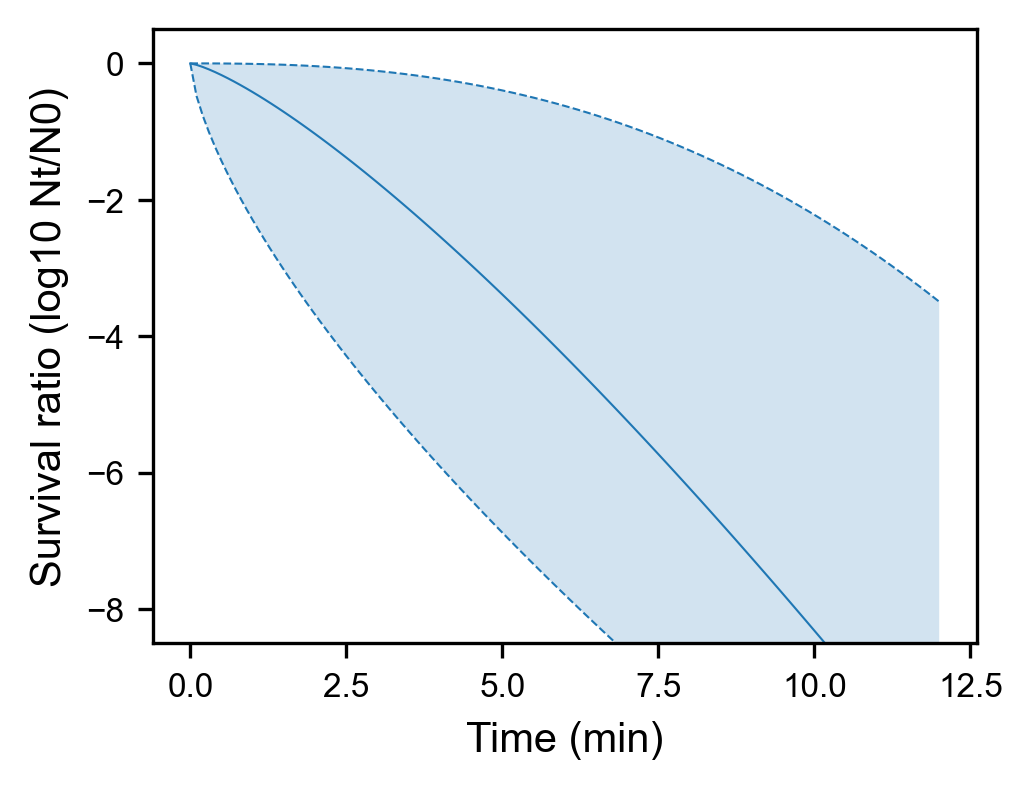

In [69]:
Palette = sns.color_palette(n_colors = 4)
plt.figure(figsize=(9*0.393701,9*0.393701*3/4), dpi=300)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_credible_mcmc_quantile[:,0], logS_credible_mcmc_quantile[:,2], facecolor=Palette[0], alpha=0.2)

plt.plot(time_interval, logS_credible_mcmc_quantile[:,0], lw=0.5,linestyle='--', color=Palette[0])
plt.plot(time_interval, logS_credible_mcmc_quantile[:,1], lw=0.5,linestyle='-', color=Palette[0])
plt.plot(time_interval, logS_credible_mcmc_quantile[:,2], lw=0.5,linestyle='--', color=Palette[0])

plt.xticks(size=8)
plt.yticks(size=8)
plt.xlabel("Time (min)",size=10,fontname="Arial")
plt.ylabel("Survival ratio (log10 Nt/N0)",size=10,fontname="Arial")
plt.ylim(-8.5,0.5)

plt.savefig("Evo_Fig/Prediction comparison rev 0.pdf", bbox_inches="tight", dpi=150)
plt.show()

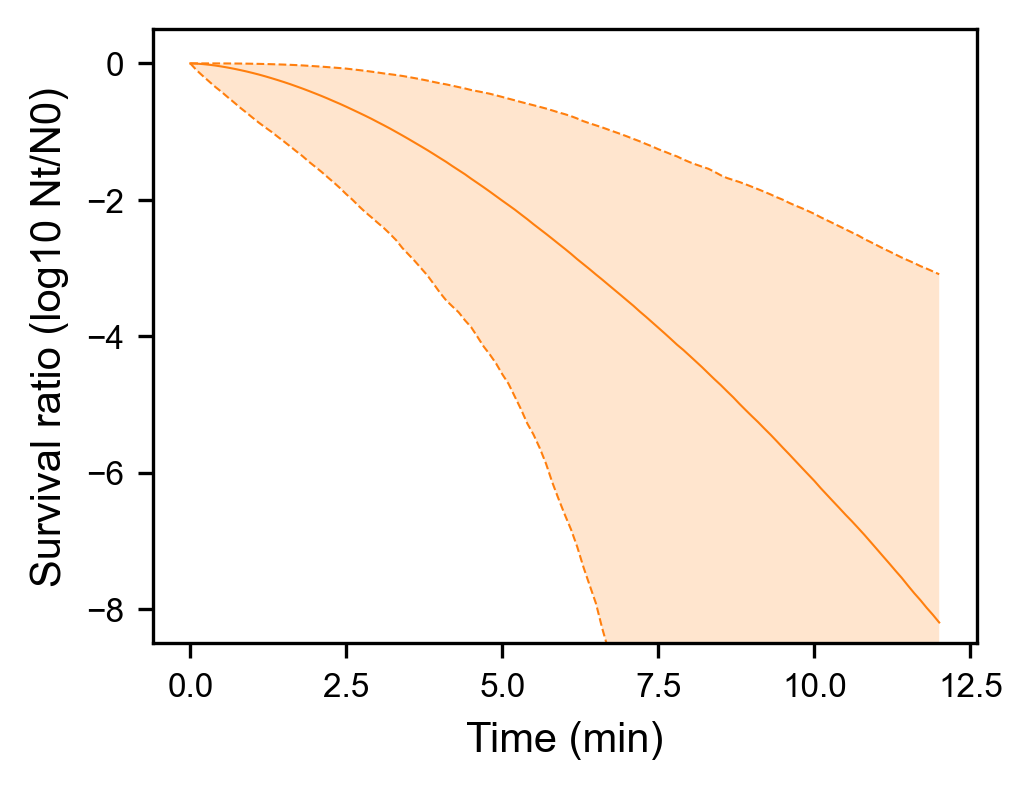

In [70]:
Palette = sns.color_palette(n_colors = 4)
plt.figure(figsize=(9*0.393701,9*0.393701*3/4), dpi=300)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_rev_credible_mcmc_quantile[:,0], logS_rev_credible_mcmc_quantile[:,2], facecolor=Palette[1], alpha=0.2)

plt.plot(time_interval, logS_rev_credible_mcmc_quantile[:,0], lw=0.5,linestyle='--', color=Palette[1])
plt.plot(time_interval, logS_rev_credible_mcmc_quantile[:,1], lw=0.5,linestyle='-', color=Palette[1])
plt.plot(time_interval, logS_rev_credible_mcmc_quantile[:,2], lw=0.5,linestyle='--', color=Palette[1])

plt.xticks(size=8)
plt.yticks(size=8)
plt.xlabel("Time (min)",size=10,fontname="Arial")
plt.ylabel("Survival ratio (log10 Nt/N0)",size=10,fontname="Arial")
plt.ylim(-8.5,0.5)

plt.savefig("Evo_Fig/Prediction comparison rev 1.pdf", bbox_inches="tight", dpi=150)
plt.show()

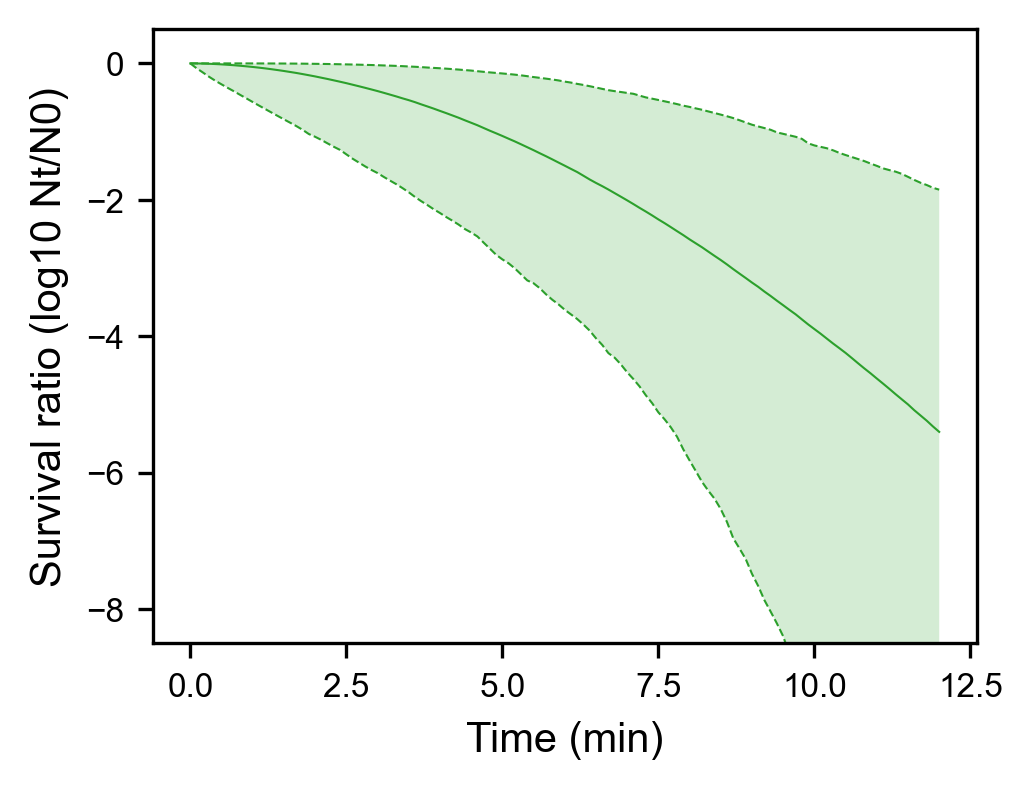

In [71]:
Palette = sns.color_palette(n_colors = 4)
plt.figure(figsize=(9*0.393701,9*0.393701*3/4), dpi=300)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_rev_2_credible_mcmc_quantile[:,0], logS_rev_2_credible_mcmc_quantile[:,2], facecolor=Palette[2], alpha=0.2)

plt.plot(time_interval, logS_rev_2_credible_mcmc_quantile[:,0], lw=0.5,linestyle='--', color=Palette[2])
plt.plot(time_interval, logS_rev_2_credible_mcmc_quantile[:,1], lw=0.5,linestyle='-', color=Palette[2])
plt.plot(time_interval, logS_rev_2_credible_mcmc_quantile[:,2], lw=0.5,linestyle='--', color=Palette[2])

plt.xticks(size=8)
plt.yticks(size=8)
plt.xlabel("Time (min)",size=10,fontname="Arial")
plt.ylabel("Survival ratio (log10 Nt/N0)",size=10,fontname="Arial")
plt.ylim(-8.5,0.5)

plt.savefig("Evo_Fig/Prediction comparison rev 2.pdf", bbox_inches="tight", dpi=150)
plt.show()

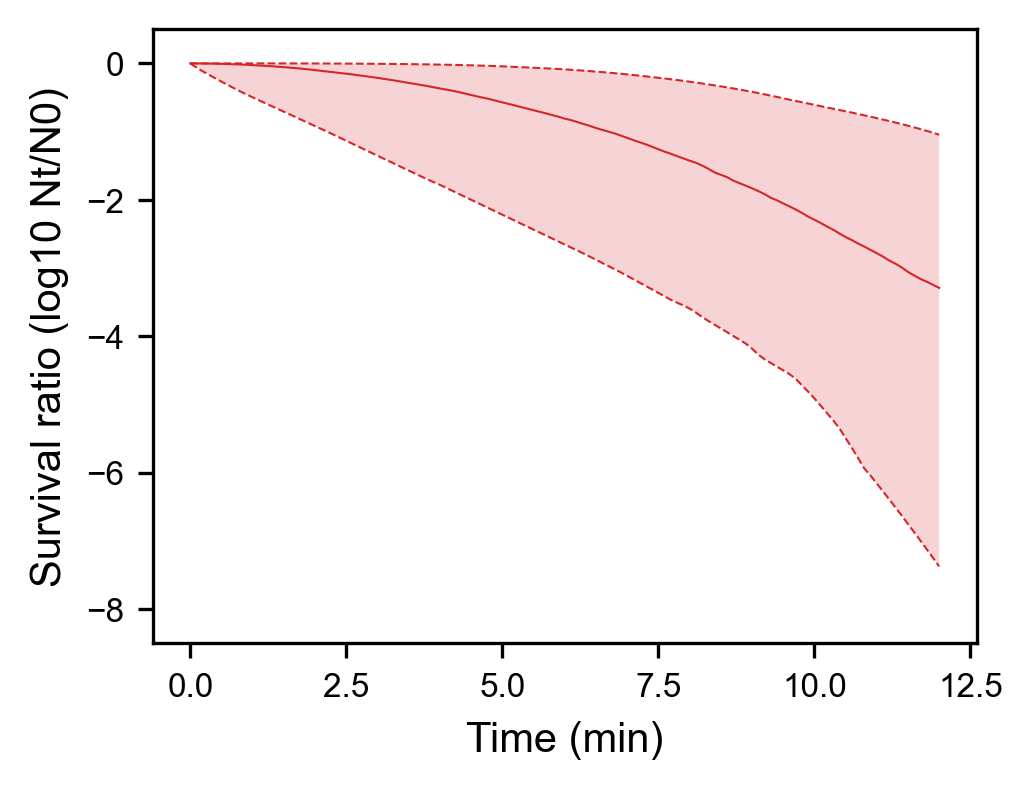

In [72]:
Palette = sns.color_palette(n_colors = 4)
plt.figure(figsize=(9*0.393701,9*0.393701*3/4), dpi=300)
plt.rcParams["font.family"] = "Arial"

plt.fill_between(time_interval, logS_rev_3_credible_mcmc_quantile[:,0], logS_rev_3_credible_mcmc_quantile[:,2], facecolor=Palette[3], alpha=0.2)

plt.plot(time_interval, logS_rev_3_credible_mcmc_quantile[:,0], lw=0.5,linestyle='--', color=Palette[3])
plt.plot(time_interval, logS_rev_3_credible_mcmc_quantile[:,1], lw=0.5,linestyle='-', color=Palette[3])
plt.plot(time_interval, logS_rev_3_credible_mcmc_quantile[:,2], lw=0.5,linestyle='--', color=Palette[3])

plt.xticks(size=8)
plt.yticks(size=8)
plt.xlabel("Time (min)",size=10,fontname="Arial")
plt.ylabel("Survival ratio (log10 Nt/N0)",size=10,fontname="Arial")
plt.ylim(-8.5,0.5)

plt.savefig("Evo_Fig/Prediction comparison rev 3.pdf", bbox_inches="tight", dpi=150)
plt.show()

In [73]:
logS_rev_credible_mcmc_quantile

array([[-0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.90584523e-02, -3.22401640e-03, -3.77298414e-06],
       [-1.83230268e-01, -1.00506152e-02, -3.38926171e-05],
       [-2.63908424e-01, -1.95903078e-02, -1.18129260e-04],
       [-3.44462646e-01, -3.13665986e-02, -2.91201967e-04],
       [-4.16788160e-01, -4.53486541e-02, -5.89807937e-04],
       [-4.95629893e-01, -6.10709238e-02, -1.02047527e-03],
       [-5.71406327e-01, -7.86112474e-02, -1.66229877e-03],
       [-6.49765453e-01, -9.77934810e-02, -2.52525341e-03],
       [-7.22318660e-01, -1.18203335e-01, -3.70517055e-03],
       [-7.97109097e-01, -1.40464743e-01, -5.20446448e-03],
       [-8.69832111e-01, -1.63969731e-01, -7.04333494e-03],
       [-9.37855017e-01, -1.89450524e-01, -9.19807556e-03],
       [-1.00265803e+00, -2.16396981e-01, -1.17378982e-02],
       [-1.07494201e+00, -2.44409453e-01, -1.46287761e-02],
       [-1.14420218e+00, -2.73650590e-01, -1.76025846e-02],
       [-1.21640040e+00, -3.04199571e-01

In [74]:
logS_credible_mcmc_quantile

array([[-0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       [-4.77460386e-01, -2.13395381e-02, -2.36699395e-05],
       [-7.65986687e-01, -5.23759161e-02, -1.32613234e-04],
       [-1.00996098e+00, -8.85596278e-02, -3.63384845e-04],
       [-1.22886763e+00, -1.28551827e-01, -7.42979166e-04],
       [-1.43084224e+00, -1.71637835e-01, -1.29391081e-03],
       [-1.62027406e+00, -2.17361392e-01, -2.03590079e-03],
       [-1.79987382e+00, -2.65401627e-01, -2.98670850e-03],
       [-1.97146463e+00, -3.15518537e-01, -4.16261705e-03],
       [-2.13634730e+00, -3.67524724e-01, -5.57874621e-03],
       [-2.29549125e+00, -4.21269147e-01, -7.24926839e-03],
       [-2.44964358e+00, -4.76627053e-01, -9.18756497e-03],
       [-2.59939553e+00, -5.33493379e-01, -1.14063440e-02],
       [-2.74522523e+00, -5.91778231e-01, -1.39177312e-02],
       [-2.88752631e+00, -6.51403681e-01, -1.67333426e-02],
       [-3.02662783e+00, -7.12301418e-01, -1.98643425e-02],
       [-3.16280839e+00, -7.74410990e-01

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

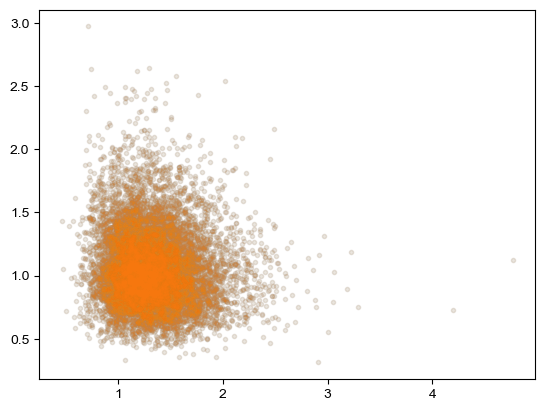

In [75]:
for j in tqdm(range(sim_num),leave=False):
    plt.scatter(np.exp(logPara_histories_non['logdelta '+str(j)].head(1)),np.exp(logPara_histories_non['logpower '+str(j)].head(1)), marker = '.', color = palette[0], alpha=0.1)
for j in tqdm(range(sim_num),leave=False):
    plt.scatter(np.exp(logPara_histories_rev['logdelta '+str(j)].head(1)),np.exp(logPara_histories_rev['logpower '+str(j)].head(1)), marker = '.', color = palette[1], alpha=0.1)
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

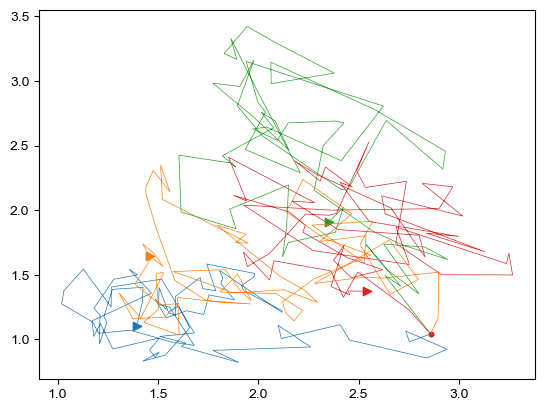

In [76]:
palette = sns.color_palette(n_colors = sim_num)
for j in tqdm([153],leave=False):
    plt.plot(np.exp(logPara_histories_non['logdelta '+str(j)]),np.exp(logPara_histories_non['logpower '+str(j)]), linewidth = 0.5, color = palette[0])
    plt.scatter(np.exp(logPara_histories_non['logdelta '+str(j)].head(1)),np.exp(logPara_histories_non['logpower '+str(j)].head(1)), marker = '.', color = palette[0])
    plt.scatter(np.exp(logPara_histories_non['logdelta '+str(j)].tail(1)),np.exp(logPara_histories_non['logpower '+str(j)].tail(1)), marker = '>', color = palette[0])
    plt.plot(np.exp(logPara_histories_rev['logdelta '+str(j)]),np.exp(logPara_histories_rev['logpower '+str(j)]), linewidth = 0.5, color = palette[1])
    plt.scatter(np.exp(logPara_histories_rev['logdelta '+str(j)].head(1)),np.exp(logPara_histories_rev['logpower '+str(j)].head(1)), marker = '.', color = palette[1])
    plt.scatter(np.exp(logPara_histories_rev['logdelta '+str(j)].tail(1)),np.exp(logPara_histories_rev['logpower '+str(j)].tail(1)), marker = '>', color  = palette[1])
    plt.plot(np.exp(logPara_histories_rev_2['logdelta '+str(j)]),np.exp(logPara_histories_rev_2['logpower '+str(j)]), linewidth = 0.5, color = palette[2])
    plt.scatter(np.exp(logPara_histories_rev_2['logdelta '+str(j)].head(1)),np.exp(logPara_histories_rev_2['logpower '+str(j)].head(1)), marker = '.', color = palette[2])
    plt.scatter(np.exp(logPara_histories_rev_2['logdelta '+str(j)].tail(1)),np.exp(logPara_histories_rev_2['logpower '+str(j)].tail(1)), marker = '>', color  = palette[2])
    plt.plot(np.exp(logPara_histories_rev_3['logdelta '+str(j)]),np.exp(logPara_histories_rev_3['logpower '+str(j)]), linewidth = 0.5, color = palette[3])
    plt.scatter(np.exp(logPara_histories_rev_3['logdelta '+str(j)].head(1)),np.exp(logPara_histories_rev_3['logpower '+str(j)].head(1)), marker = '.', color = palette[3])
    plt.scatter(np.exp(logPara_histories_rev_3['logdelta '+str(j)].tail(1)),np.exp(logPara_histories_rev_3['logpower '+str(j)].tail(1)), marker = '>', color  = palette[3])
plt.show()

In [77]:
sim_num = 1000
revo_num = 100
cell_counts = 10**6
thermal_trial_lim = 100
L_para = 1
processor_num = 8

In [78]:
t_heating = 10
warnings.simplefilter('ignore', RuntimeWarning)
Sim_results =[]
ns = range(sim_num)
with ProcessPoolExecutor(processor_num) as e:
    ret = e.map(heat_rev, ns)
logPara_histories = [r for r in ret]
logPara_histories = pd.concat(logPara_histories, axis=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

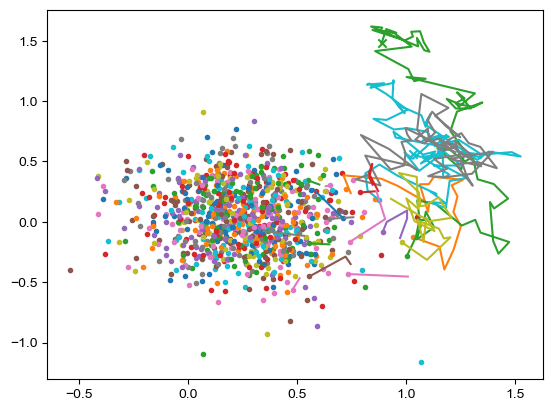

In [79]:
palette = sns.color_palette(n_colors = sim_num)
for j in tqdm(range(sim_num),leave=False):
    plt.plot(logPara_histories['logdelta '+str(j)],logPara_histories['logpower '+str(j)], color = palette[j])
    plt.scatter(logPara_histories['logdelta '+str(j)].head(1),logPara_histories['logpower '+str(j)].head(1), marker = '.', color = palette[j])
    plt.scatter(logPara_histories['logdelta '+str(j)].tail(1),logPara_histories['logpower '+str(j)].tail(1), marker = 'x', color = palette[j])
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

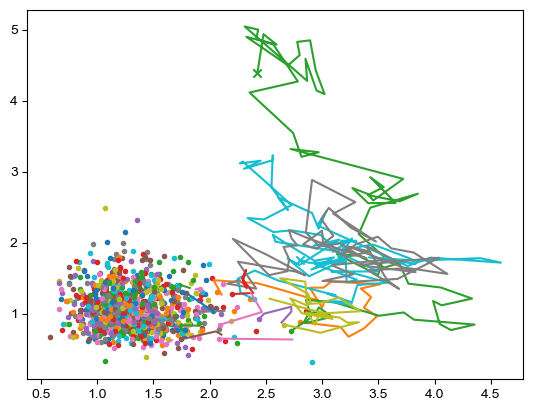

In [80]:
palette = sns.color_palette(n_colors = sim_num)
for j in tqdm(range(sim_num),leave=False):
    plt.plot(np.exp(logPara_histories['logdelta '+str(j)]),np.exp(logPara_histories['logpower '+str(j)]), color = palette[j])
    plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].head(1)),np.exp(logPara_histories['logpower '+str(j)].head(1)), marker = '.', color = palette[j])
    plt.scatter(np.exp(logPara_histories['logdelta '+str(j)].tail(1)),np.exp(logPara_histories['logpower '+str(j)].tail(1)), marker = 'x', color = palette[j])
plt.show()

In [81]:
logPara_histories_rev_L_para_01 = logPara_histories

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

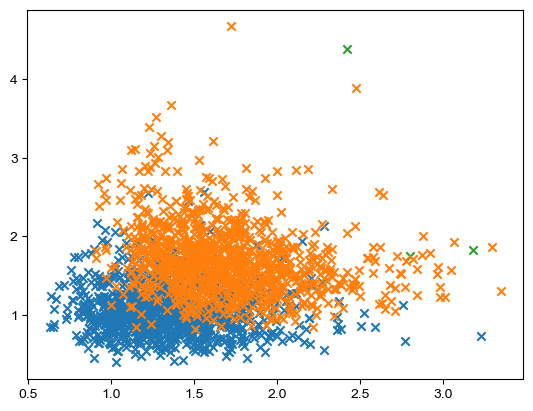

In [82]:
for j in tqdm(range(sim_num),leave=False):
    plt.scatter(np.exp(logPara_histories_rev_L_para_01['logdelta '+str(j)].tail(1)),np.exp(logPara_histories_rev_L_para_01['logpower '+str(j)].tail(1)), marker = 'x', color = palette[2])
for j in tqdm(range(sim_num),leave=False):
    plt.scatter(np.exp(logPara_histories_non['logdelta '+str(j)].tail(1)),np.exp(logPara_histories_non['logpower '+str(j)].tail(1)), marker = 'x', color = palette[0])
for j in tqdm(range(sim_num),leave=False):
    plt.scatter(np.exp(logPara_histories_rev['logdelta '+str(j)].tail(1)),np.exp(logPara_histories_rev['logpower '+str(j)].tail(1)), marker = 'x', color = palette[1])
plt.show()